In [2]:
import torch
import os
nodes = [(0, {'pos': (0.1, 0.65)}),
         (1, {'pos': (0.05, 0.05)}), 
         (2, {'pos': (0.2, 0.15)}), 
         (3, {'pos': (0.55, 0.05)}),
         (4, {'pos': (0.8, 0.05)}),
         (5, {'pos': (0.9, 0.1)}),
         (6, {'pos': (0.75, 0.15)}),
         (7, {'pos': (0.5, 0.2)}),
         (8, {'pos': (0.3, 0.3)}),
         (9, {'pos': (0.2, 0.3)}),
         (10, {'pos': (0.3, 0.4)}),
         (11, {'pos': (0.65, 0.35)}),
         (12, {'pos': (0.8, 0.5)}),
         (13, {'pos': (0.5, 0.5)}),
         (14, {'pos': (0.4, 0.65)}),
         (15, {'pos': (0.15, 0.6)}),
         (16, {'pos': (0.3, 0.7)}),
         (17, {'pos': (0.5, 0.7)}),
         (18, {'pos': (0.8, 0.8)}),
         (19, {'pos': (0.4, 0.8)}),
         (20, {'pos': (0.25, 0.85)}),
         (21, {'pos': (0.1, 0.9)}),
         (22, {'pos': (0.2, 0.95)}),
         (23, {'pos': (0.45, 0.9)}),
         (24, {'pos': (0.95, 0.95)}),
         (25, {'pos': (0.9, 0.4)}),
         (26, {'pos': (0.95, 0.05)})]
edges = [(0, 21), (0, 1), (0, 15), (21, 22), (22, 20), (20, 23), (23, 24), (24, 18), (19, 14), (14, 15), (15, 16), (16, 20), (19, 20), (19, 17), (14, 17), (14, 16), (17, 18), (12, 18), (12, 13), (13, 14), (10, 14), (1, 15), (9, 15), (1, 9), (1, 2), (11, 12), (9, 10), (3, 7), (2, 3), (7, 8), (8, 9), (8, 10), (10, 11), (8, 11), (6, 11), (3, 4), (4, 5), (4, 6), (5, 6), (24, 25), (12, 25), (5, 25), (11, 25), (5, 26)]

def visualize_predictions(samples, ground_truth_hist, ground_truth_fut, num_samples=5):
        """
        Visualize the predictions of the model along with ground truth data.

        :param samples: A list of predicted edge indices.
        :param ground_truth_hist: A list of actual history edge indices.
        :param ground_truth_fut: A list of actual future edge indices.
        :param num_samples: Number of samples to visualize.
        """
        import matplotlib.pyplot as plt
        import networkx as nx
        '''save_dir = f'{os.path.join(model_dir, f'{exp_name}', 'plots')}'
        os.makedirs(save_dir, exist_ok=True)'''
        G = nx.Graph()
        G.add_nodes_from(nodes)
        all_edges = {tuple(edges[idx]) for idx in range(len(edges))}
        G.add_edges_from(all_edges)
        
        pos = nx.get_node_attributes(G, 'pos')  # Retrieve node positions stored in node attributes

        for i in range(min(num_samples, len(samples))):
            plt.figure(figsize=(18, 8))            

            for plot_num, (title, edge_indices) in enumerate([
                ('Ground Truth History', ground_truth_hist[i]),
                ('Ground Truth Future', ground_truth_fut[i]),
                ('Predicted Future', samples[i])
            ]):
                plt.subplot(1, 3, plot_num + 1)
                plt.title(title)
                subgraph_edges = {tuple(edges[idx]) for idx in edge_indices if idx < len(edges)}

                # Draw all edges as muted gray
                nx.draw_networkx_edges(G, pos, edgelist=all_edges, width=0.5, alpha=0.3, edge_color='gray')

                # Draw subgraph edges with specified color
                edge_color = 'gray' if plot_num == 0 else 'green' if plot_num == 1 else 'red'
                node_color = 'skyblue'# if plot_num == 0 else 'lightgreen' if plot_num == 1 else 'orange'
                nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=500)
                nx.draw_networkx_edges(G, pos, edgelist=subgraph_edges, width=3, alpha=1.0, edge_color=edge_color)
                nx.draw_networkx_labels(G, pos, font_size=15)
            plt.show()

In [3]:
samples = [[12, 13, 16], [4, 3], [21, 10], [37, 34]]
ground_truth_hist = [[1, 0, 3, 4, 5], [32, 25, 17, 7, 6], [11, 15, 20, 26, 23], [22, 30, 29, 27, 35]] 
ground_truth_fut = [[6, 7], [5, 4], [24, 28], [36, 43]]

visualize_predictions(samples, ground_truth_hist, ground_truth_fut, num_samples=5)

KeyboardInterrupt: 

In [ ]:
import h5py
from tqdm import tqdm
TDRIVE_PATH = '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/tdrive.h5'
def load_new_format(new_file_path):
    paths = []

    with h5py.File(new_file_path, 'r') as new_hf:
        node_coordinates = new_hf['graph']['node_coordinates'][:]
        edges = new_hf['graph']['edges'][:]
        
        for i in tqdm(new_hf['trajectories'].keys()):
                path_group = new_hf['trajectories'][i]
                path = {attr: path_group[attr][()] for attr in path_group.keys()}
                if 'edge_orientation' in path:
                    path['edge_orientations'] = path.pop('edge_orientation')
                paths.append(path)
    nodes = [(i, {'pos': tuple(pos)}) for i, pos in enumerate(node_coordinates)]
    
    return paths, nodes, edges

In [ ]:
paths, nodes, edges = load_new_format(TDRIVE_PATH)

  0%|          | 0/7218 [00:00<?, ?it/s]

100%|██████████| 7218/7218 [00:13<00:00, 542.96it/s]


In [ ]:
edges

array([[   0, 6154],
       [   0, 8268],
       [   0, 3616],
       ...,
       [9737, 9751],
       [9747, 9805],
       [9759, 9809]])

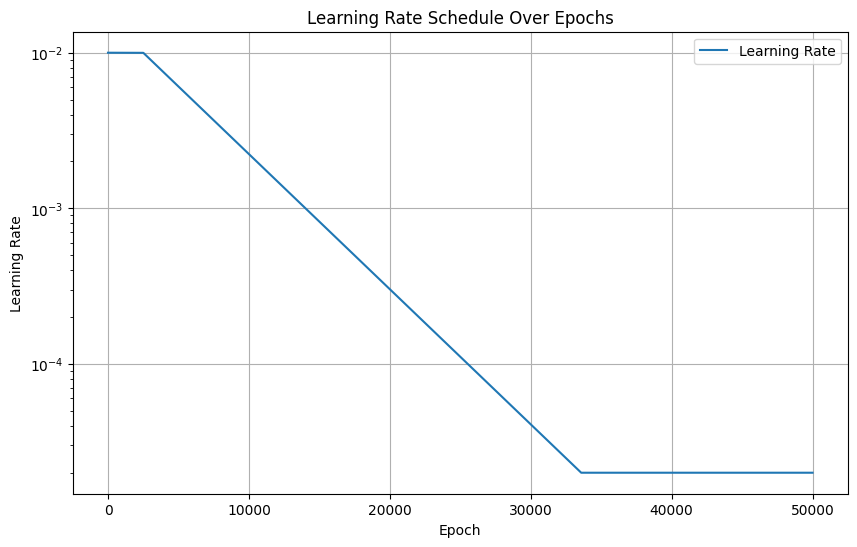

In [ ]:
import matplotlib.pyplot as plt

# Parameters
lr = 0.01
num_epochs = 50000
learning_rate_warmup_steps = 2500
lr_decay_parameter = 0.9998

# Learning rate schedule
def lr_lambda(epoch):
    if epoch < learning_rate_warmup_steps:
        return 1.0
    else:
        decay_lr = lr_decay_parameter ** (epoch - learning_rate_warmup_steps)
        return max(decay_lr, 2e-5 / lr)


# Calculate learning rates for each epoch
learning_rates = [lr * lr_lambda(epoch) for epoch in range(num_epochs)]

# Plot the learning rates
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')#
plt.yscale('log')
plt.title('Learning Rate Schedule Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
nodes = [(0, {'pos': (0.1, 0.65)}),
         (1, {'pos': (0.05, 0.05)}), 
         (2, {'pos': (0.2, 0.15)}), 
         (3, {'pos': (0.55, 0.05)}),
         (4, {'pos': (0.8, 0.05)}),
         (5, {'pos': (0.9, 0.1)}),
         (6, {'pos': (0.75, 0.15)}),
         (7, {'pos': (0.5, 0.2)}),
         (8, {'pos': (0.3, 0.3)}),
         (9, {'pos': (0.2, 0.3)}),
         (10, {'pos': (0.3, 0.4)}),
         (11, {'pos': (0.65, 0.35)}),
         (12, {'pos': (0.8, 0.5)}),
         (13, {'pos': (0.5, 0.5)}),
         (14, {'pos': (0.4, 0.65)}),
         (15, {'pos': (0.15, 0.6)}),
         (16, {'pos': (0.3, 0.7)}),
         (17, {'pos': (0.5, 0.7)}),
         (18, {'pos': (0.8, 0.8)}),
         (19, {'pos': (0.4, 0.8)}),
         (20, {'pos': (0.25, 0.85)}),
         (21, {'pos': (0.1, 0.9)}),
         (22, {'pos': (0.2, 0.95)}),
         (23, {'pos': (0.45, 0.9)}),
         (24, {'pos': (0.95, 0.95)}),
         (25, {'pos': (0.9, 0.4)}),
         (26, {'pos': (0.95, 0.05)}),
         (27, {'pos': (0.75, 1.0)})]
edges = [(0, 21), (0, 1), (0, 15), (21, 22), (22, 20), (20, 23), (23, 24), (24, 18), (19, 14), (14, 15), (15, 16), (16, 20), (19, 20), (19, 17), (14, 17), (14, 16), (17, 18), (12, 18), (12, 13), (13, 14), (10, 14), (1, 15), (9, 15), (1, 9), (1, 2), (11, 12), (9, 10), (3, 7), (2, 3), (7, 8), (8, 9), (8, 10), (10, 11), (8, 11), (6, 11), (3, 4), (4, 5), (4, 6), (5, 6), (24, 25), (12, 25), (5, 25), (11, 25), (5, 26), (23, 27), (24, 27)]


In [2]:
import torch
from torch import tensor
res = {'sample_list': [tensor([ 0,  2,  7, 11, 15, 20, 23, 24, 26, 29, 30, 34, 35, 36, 37, 39, 45]), tensor([ 0,  2,  7, 23, 24, 26, 29, 30, 34, 35, 36, 37, 39, 45]), tensor([ 0,  2, 23, 24, 30, 34, 37]), tensor([ 0,  2, 23, 24, 26, 29, 30, 34, 36, 37]), tensor([ 0,  2, 23, 24, 26, 29, 30, 34, 35, 36, 37]), tensor([ 0,  2, 23, 24, 30]), tensor([ 4, 12, 17, 18, 19, 21, 24, 40, 41]), tensor([ 0,  2, 23, 24, 26, 29, 30, 34, 35, 36, 37, 45]), tensor([ 0,  2, 23, 24, 30, 34, 36, 37]), tensor([ 4, 12, 17, 18, 21, 24, 40, 41]), tensor([ 0,  2, 23, 24, 26, 29, 30, 34, 36, 37]), tensor([ 4, 12, 17, 18, 19, 21, 24, 40, 41]), tensor([ 0,  2,  7, 11, 15, 20, 23, 24, 26, 29, 30, 34, 35, 36, 37, 39, 45]), tensor([ 0,  2, 23, 24, 26, 29, 30, 34, 35, 36, 37]), tensor([ 4, 12, 17, 18, 19, 21, 24, 40, 41]), tensor([ 4, 12, 17, 18, 19, 21, 24, 40, 41]), tensor([ 0,  2,  7, 23, 24, 26, 29, 30, 34, 35, 36, 37, 39, 45]), tensor([ 0,  2, 23, 24, 30, 34, 37]), tensor([ 0,  2, 23, 24, 26, 29, 30, 34, 36, 37]), tensor([ 0,  2, 23, 24, 26, 29, 30, 34, 36, 37])], 'ground_truth_hist': [tensor([[43, 36, 37, 34, 32]]), tensor([[23, 26, 20, 14, 16]]), tensor([[40, 18, 19, 14, 13]]), tensor([[ 5, 12,  8, 20, 32]]), tensor([[39, 41, 36, 35, 27]]), tensor([[44,  5, 11, 10, 22]]), tensor([[24, 28, 35, 36, 41]]), tensor([[ 9, 19, 18, 40, 41]]), tensor([[35, 27, 29, 30, 22]]), tensor([[39, 42, 33, 30, 22]]), tensor([[41, 40, 18, 19,  8]]), tensor([[ 0,  3,  4, 11, 15]]), tensor([[38, 34, 25, 18, 19]]), tensor([[ 7, 16, 13,  8, 20]]), tensor([[ 3,  4, 11, 15, 19]]), tensor([[10, 15, 14, 16, 17]]), tensor([[26, 32, 34, 38, 41]]), tensor([[45,  7, 17, 25, 33]]), tensor([[37, 34, 32, 26, 22]]), tensor([[ 2, 22, 26, 32, 34]])], 'ground_truth_fut': [tensor([[20, 15]]), tensor([[ 7, 45]]), tensor([[12,  4]]), tensor([[34, 37]]), tensor([[29, 30]]), tensor([[23, 24]]), tensor([[40, 17]]), tensor([[36, 35]]), tensor([[2, 0]]), tensor([[21, 24]]), tensor([[12,  4]]), tensor([[19, 18]]), tensor([[15, 11]]), tensor([[26, 23]]), tensor([[18, 40]]), tensor([[40, 41]]), tensor([[39, 45]]), tensor([[30, 23]]), tensor([[2, 0]]), tensor([[37, 36]])]}
samples = res['sample_list']
one_hot_samples = [torch.zeros(len(edges)) for _ in range(len(samples))]
ground_truth_fut = res['ground_truth_fut']
one_hot_futures = [torch.zeros(len(edges)) for _ in range(len(ground_truth_fut))]
for i, one_hot_sample in enumerate(one_hot_samples):
    for edge_index, edge in enumerate(edges):
        if edge_index in samples[i]:
            one_hot_sample[edges.index(edge)] = 1
for i, one_hot_fut in enumerate(one_hot_futures):
    for edge_index, edge in enumerate(edges):
        if edge_index in ground_truth_fut[i]:
            one_hot_fut[edges.index(edge)] = 1

In [3]:
from torchmetrics import F1Score
metric = F1Score(task='binary', average='micro', num_classes=2)
f1 = metric(torch.cat(one_hot_samples), torch.cat(one_hot_futures))
print(f1)

tensor(0.2915)


## With 1 sample

In [4]:
res = {'sample_list': [tensor([17, 37, 40]), tensor([ 0,  1,  2,  6,  7, 16, 19, 20, 21, 26, 29, 38, 39, 45]), tensor([15, 18, 19]), tensor([ 0,  1,  2, 16, 20, 21, 26]), tensor([37]), tensor([10, 11, 18, 32, 36]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([11, 18, 32, 36, 39, 40]), tensor([ 0,  1,  2, 13, 21, 24, 27, 28, 29, 30, 34]), tensor([16, 17, 23, 24, 34, 37, 40, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([18, 40]), tensor([15, 18, 19]), tensor([11, 18, 32, 36, 40]), tensor([40, 41]), tensor([15, 18, 19]), tensor([11, 32, 36, 39, 40]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([18]), tensor([15, 18, 19, 45])], 'ground_truth_hist': [tensor([[24, 28, 35, 36, 41]]), tensor([[23, 26, 20, 14, 16]]), tensor([[ 7, 16, 13,  8, 20]]), tensor([[ 5, 12,  8, 20, 32]]), tensor([[43, 36, 37, 34, 32]]), tensor([[38, 34, 25, 18, 19]]), tensor([[35, 27, 29, 30, 22]]), tensor([[41, 40, 18, 19,  8]]), tensor([[39, 42, 33, 30, 22]]), tensor([[39, 41, 36, 35, 27]]), tensor([[37, 34, 32, 26, 22]]), tensor([[40, 18, 19, 14, 13]]), tensor([[ 0,  3,  4, 11, 15]]), tensor([[ 9, 19, 18, 40, 41]]), tensor([[10, 15, 14, 16, 17]]), tensor([[ 3,  4, 11, 15, 19]]), tensor([[26, 32, 34, 38, 41]]), tensor([[ 2, 22, 26, 32, 34]]), tensor([[44,  5, 11, 10, 22]]), tensor([[45,  7, 17, 25, 33]])], 'ground_truth_fut': [tensor([[40, 17]]), tensor([[ 7, 45]]), tensor([[26, 23]]), tensor([[34, 37]]), tensor([[20, 15]]), tensor([[15, 11]]), tensor([[2, 0]]), tensor([[12,  4]]), tensor([[21, 24]]), tensor([[29, 30]]), tensor([[2, 0]]), tensor([[12,  4]]), tensor([[19, 18]]), tensor([[36, 35]]), tensor([[40, 41]]), tensor([[18, 40]]), tensor([[39, 45]]), tensor([[37, 36]]), tensor([[23, 24]]), tensor([[30, 23]])]}

In [5]:
samples = res['sample_list']
one_hot_samples = [torch.zeros(len(edges)) for _ in range(len(samples))]
ground_truth_fut = res['ground_truth_fut']
one_hot_futures = [torch.zeros(len(edges)) for _ in range(len(ground_truth_fut))]
for i, one_hot_sample in enumerate(one_hot_samples):
    for edge_index, edge in enumerate(edges):
        if edge_index in samples[i]:
            one_hot_sample[edges.index(edge)] = 1
for i, one_hot_fut in enumerate(one_hot_futures):
    for edge_index, edge in enumerate(edges):
        if edge_index in ground_truth_fut[i]:
            one_hot_fut[edges.index(edge)] = 1
            
metric = F1Score(task='binary', average='micro', num_classes=2)
f1 = metric(torch.cat(one_hot_samples), torch.cat(one_hot_futures))
print(f1)

tensor(0.1900)


## With 10 samples

In [6]:
res = {'sample_list': [[tensor([17, 37, 40]), tensor([17, 37, 40]), tensor([17, 37, 40]), tensor([17, 37, 40]), tensor([17, 37, 40]), tensor([17, 37, 40]), tensor([17, 37, 40]), tensor([17, 37, 40]), tensor([17, 37, 40]), tensor([17, 37, 40])], [tensor([ 0,  1,  2,  6,  7, 16, 19, 20, 21, 26, 29, 38, 39, 45]), tensor([ 0,  1,  2,  6,  7, 16, 19, 20, 21, 26, 29, 38, 39, 45]), tensor([ 0,  1,  2,  6,  7, 16, 19, 20, 21, 26, 29, 38, 39, 45]), tensor([ 0,  1,  2,  6,  7, 16, 19, 20, 21, 26, 29, 38, 39, 45]), tensor([ 0,  1,  2,  6,  7, 16, 19, 20, 21, 26, 29, 38, 39, 45]), tensor([ 0,  1,  2,  6,  7, 16, 19, 20, 21, 26, 29, 38, 39, 45]), tensor([ 0,  1,  2,  6,  7, 16, 19, 20, 21, 26, 29, 38, 39, 45]), tensor([ 0,  1,  2,  6,  7, 16, 19, 20, 21, 26, 29, 38, 39, 45]), tensor([ 0,  1,  2,  6,  7, 16, 19, 20, 21, 26, 29, 38, 39, 45]), tensor([ 0,  1,  2,  6,  7, 16, 19, 20, 21, 26, 29, 38, 39, 45])], [tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19])], [tensor([ 0,  1,  2, 16, 20, 21, 26]), tensor([ 0,  1,  2, 16, 20, 21, 26]), tensor([ 0,  1,  2, 16, 20, 21, 26]), tensor([ 0,  1,  2, 16, 20, 21, 26]), tensor([ 0,  1,  2, 16, 20, 21, 26]), tensor([ 0,  1,  2, 16, 20, 21, 26]), tensor([ 0,  1,  2, 16, 20, 21, 26]), tensor([ 0,  1,  2, 16, 20, 21, 26]), tensor([ 0,  1,  2, 16, 20, 21, 26]), tensor([ 0,  1,  2, 16, 20, 21, 26])], [tensor([37]), tensor([37]), tensor([37]), tensor([37]), tensor([37]), tensor([37]), tensor([37]), tensor([37]), tensor([37]), tensor([37])], [tensor([10, 11, 18, 32, 36]), tensor([10, 11, 18, 32, 36]), tensor([10, 11, 18, 32, 36]), tensor([10, 11, 18, 32, 36]), tensor([10, 11, 18, 32, 36]), tensor([10, 11, 18, 32, 36]), tensor([10, 11, 18, 32, 36]), tensor([10, 11, 18, 32, 36]), tensor([10, 11, 18, 32, 36]), tensor([10, 11, 18, 32, 36])], [tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45])], [tensor([11, 18, 32, 36, 39, 40]), tensor([11, 18, 32, 36, 39, 40]), tensor([11, 18, 32, 36, 39, 40]), tensor([11, 18, 32, 36, 39, 40]), tensor([11, 18, 32, 36, 39, 40]), tensor([11, 18, 32, 36, 39, 40]), tensor([11, 18, 32, 36, 39, 40]), tensor([11, 18, 32, 36, 39, 40]), tensor([11, 18, 32, 36, 39, 40]), tensor([11, 18, 32, 36, 39, 40])], [tensor([ 0,  1,  2, 13, 21, 24, 27, 28, 29, 30, 34]), tensor([ 0,  1,  2, 13, 21, 24, 27, 28, 29, 30, 34]), tensor([ 0,  1,  2, 13, 21, 24, 27, 28, 29, 30, 34]), tensor([ 0,  1,  2, 13, 21, 24, 27, 28, 29, 30, 34]), tensor([ 0,  1,  2, 13, 21, 24, 27, 28, 29, 30, 34]), tensor([ 0,  1,  2, 13, 21, 24, 27, 28, 29, 30, 34]), tensor([ 0,  1,  2, 13, 21, 24, 27, 28, 29, 30, 34]), tensor([ 0,  1,  2, 13, 21, 24, 27, 28, 29, 30, 34]), tensor([ 0,  1,  2, 13, 21, 24, 27, 28, 29, 30, 34]), tensor([ 0,  1,  2, 13, 21, 24, 27, 28, 29, 30, 34])], [tensor([16, 17, 23, 24, 34, 37, 40, 43, 44, 45]), tensor([16, 17, 23, 24, 34, 37, 40, 43, 44, 45]), tensor([16, 17, 23, 24, 34, 37, 40, 43, 44, 45]), tensor([16, 17, 23, 24, 34, 37, 40, 43, 44, 45]), tensor([16, 17, 23, 24, 34, 37, 40, 43, 44, 45]), tensor([16, 17, 23, 24, 34, 37, 40, 43, 44, 45]), tensor([16, 17, 23, 24, 34, 37, 40, 43, 44, 45]), tensor([16, 17, 23, 24, 34, 37, 40, 43, 44, 45]), tensor([16, 17, 23, 24, 34, 37, 40, 43, 44, 45]), tensor([16, 17, 23, 24, 34, 37, 40, 43, 44, 45])], [tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45])], [tensor([18, 40]), tensor([18, 40]), tensor([18, 40]), tensor([18, 40]), tensor([18, 40]), tensor([18, 40]), tensor([18, 40]), tensor([18, 40]), tensor([18, 40]), tensor([18, 40])], [tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19])], [tensor([11, 18, 32, 36, 40]), tensor([11, 18, 32, 36, 40]), tensor([11, 18, 32, 36, 40]), tensor([11, 18, 32, 36, 40]), tensor([11, 18, 32, 36, 40]), tensor([11, 18, 32, 36, 40]), tensor([11, 18, 32, 36, 40]), tensor([11, 18, 32, 36, 40]), tensor([11, 18, 32, 36, 40]), tensor([11, 18, 32, 36, 40])], [tensor([40, 41]), tensor([40, 41]), tensor([40, 41]), tensor([40, 41]), tensor([40, 41]), tensor([40, 41]), tensor([40, 41]), tensor([40, 41]), tensor([40, 41]), tensor([40, 41])], [tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19]), tensor([15, 18, 19])], [tensor([11, 32, 36, 39, 40]), tensor([11, 32, 36, 39, 40]), tensor([11, 32, 36, 39, 40]), tensor([11, 32, 36, 39, 40]), tensor([11, 32, 36, 39, 40]), tensor([11, 32, 36, 39, 40]), tensor([11, 32, 36, 39, 40]), tensor([11, 32, 36, 39, 40]), tensor([11, 32, 36, 39, 40]), tensor([11, 32, 36, 39, 40])], [tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45])], [tensor([18]), tensor([18]), tensor([18]), tensor([18]), tensor([18]), tensor([18]), tensor([18]), tensor([18]), tensor([18]), tensor([18])], [tensor([15, 18, 19, 45]), tensor([15, 18, 19, 45]), tensor([15, 18, 19, 45]), tensor([15, 18, 19, 45]), tensor([15, 18, 19, 45]), tensor([15, 18, 19, 45]), tensor([15, 18, 19, 45]), tensor([15, 18, 19, 45]), tensor([15, 18, 19, 45]), tensor([15, 18, 19, 45])]], 'ground_truth_hist': [tensor([[24, 28, 35, 36, 41]]), tensor([[23, 26, 20, 14, 16]]), tensor([[ 7, 16, 13,  8, 20]]), tensor([[ 5, 12,  8, 20, 32]]), tensor([[43, 36, 37, 34, 32]]), tensor([[38, 34, 25, 18, 19]]), tensor([[35, 27, 29, 30, 22]]), tensor([[41, 40, 18, 19,  8]]), tensor([[39, 42, 33, 30, 22]]), tensor([[39, 41, 36, 35, 27]]), tensor([[37, 34, 32, 26, 22]]), tensor([[40, 18, 19, 14, 13]]), tensor([[ 0,  3,  4, 11, 15]]), tensor([[ 9, 19, 18, 40, 41]]), tensor([[10, 15, 14, 16, 17]]), tensor([[ 3,  4, 11, 15, 19]]), tensor([[26, 32, 34, 38, 41]]), tensor([[ 2, 22, 26, 32, 34]]), tensor([[44,  5, 11, 10, 22]]), tensor([[45,  7, 17, 25, 33]])], 'ground_truth_fut': [tensor([[40, 17]]), tensor([[ 7, 45]]), tensor([[26, 23]]), tensor([[34, 37]]), tensor([[20, 15]]), tensor([[15, 11]]), tensor([[2, 0]]), tensor([[12,  4]]), tensor([[21, 24]]), tensor([[29, 30]]), tensor([[2, 0]]), tensor([[12,  4]]), tensor([[19, 18]]), tensor([[36, 35]]), tensor([[40, 41]]), tensor([[18, 40]]), tensor([[39, 45]]), tensor([[37, 36]]), tensor([[23, 24]]), tensor([[30, 23]])]}

In [7]:
samples = [res['sample_list'][i][0] for i in range(len(res['sample_list']))]
print(samples)
one_hot_samples = [torch.zeros(len(edges)) for _ in range(len(samples))]
ground_truth_fut = res['ground_truth_fut']
one_hot_futures = [torch.zeros(len(edges)) for _ in range(len(ground_truth_fut))]
for i, one_hot_sample in enumerate(one_hot_samples):
    for edge_index, edge in enumerate(edges):
        if edge_index in samples[i]:
            one_hot_sample[edges.index(edge)] = 1
for i, one_hot_fut in enumerate(one_hot_futures):
    for edge_index, edge in enumerate(edges):
        if edge_index in ground_truth_fut[i]:
            one_hot_fut[edges.index(edge)] = 1
            
metric = F1Score(task='binary', average='macro', num_classes=2)
f1_tot = 0
for i in range(len(res['sample_list'])):
    f1 = metric(one_hot_samples[i], one_hot_futures[i])
    f1_tot += f1
f1 = f1_tot / len(res['sample_list'])
print(one_hot_samples[0])
print(f1)

[tensor([17, 37, 40]), tensor([ 0,  1,  2,  6,  7, 16, 19, 20, 21, 26, 29, 38, 39, 45]), tensor([15, 18, 19]), tensor([ 0,  1,  2, 16, 20, 21, 26]), tensor([37]), tensor([10, 11, 18, 32, 36]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([11, 18, 32, 36, 39, 40]), tensor([ 0,  1,  2, 13, 21, 24, 27, 28, 29, 30, 34]), tensor([16, 17, 23, 24, 34, 37, 40, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([18, 40]), tensor([15, 18, 19]), tensor([11, 18, 32, 36, 40]), tensor([40, 41]), tensor([15, 18, 19]), tensor([11, 32, 36, 39, 40]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([18]), tensor([15, 18, 19, 45])]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [8]:
sample_10 = [tensor([17, 37, 40]), tensor([ 0,  1,  2,  6,  7, 16, 19, 20, 21, 26, 29, 38, 39, 45]), tensor([15, 18, 19]), tensor([ 0,  1,  2, 16, 20, 21, 26]), tensor([37]), tensor([10, 11, 18, 32, 36]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([11, 18, 32, 36, 39, 40]), tensor([ 0,  1,  2, 13, 21, 24, 27, 28, 29, 30, 34]), tensor([16, 17, 23, 24, 34, 37, 40, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([18, 40]), tensor([15, 18, 19]), tensor([11, 18, 32, 36, 40]), tensor([40, 41]), tensor([15, 18, 19]), tensor([11, 32, 36, 39, 40]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([18]), tensor([15, 18, 19, 45])]
sample_1 = [tensor([17, 37, 40]), tensor([ 0,  1,  2,  6,  7, 16, 19, 20, 21, 26, 29, 38, 39, 45]), tensor([15, 18, 19]), tensor([ 0,  1,  2, 16, 20, 21, 26]), tensor([37]), tensor([10, 11, 18, 32, 36]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([11, 18, 32, 36, 39, 40]), tensor([ 0,  1,  2, 13, 21, 24, 27, 28, 29, 30, 34]), tensor([16, 17, 23, 24, 34, 37, 40, 43, 44, 45]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([18, 40]), tensor([15, 18, 19]), tensor([11, 18, 32, 36, 40]), tensor([40, 41]), tensor([15, 18, 19]), tensor([11, 32, 36, 39, 40]), tensor([ 0,  1,  2,  6,  7,  8,  9, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24, 34,
        37, 40, 41, 42, 43, 44, 45]), tensor([18]), tensor([15, 18, 19, 45])]
for j in range(10):
        sample_10 = [res['sample_list'][i][j] for i in range(len(res['sample_list']))]
        equal = 0
        for i in range(len(sample_10)):
                if sample_10[i].equal(sample_1[i]):
                        equal += 1
                
        print(f"Ratio of equal samples for sample {j}:", equal/len(sample_10))

Ratio of equal samples for sample 0: 1.0
Ratio of equal samples for sample 1: 1.0
Ratio of equal samples for sample 2: 1.0
Ratio of equal samples for sample 3: 1.0
Ratio of equal samples for sample 4: 1.0
Ratio of equal samples for sample 5: 1.0
Ratio of equal samples for sample 6: 1.0
Ratio of equal samples for sample 7: 1.0
Ratio of equal samples for sample 8: 1.0
Ratio of equal samples for sample 9: 1.0


In [9]:
res = {'sample_list': [tensor([11, 12, 18, 19]), tensor([18, 19]), tensor([18, 19]), tensor([35, 36]), tensor([11, 12]), tensor([11, 12]), tensor([18, 19]), tensor([41]), tensor([24, 35, 36]), tensor([24, 35, 36]), tensor([11, 12, 19]), tensor([20, 21, 40, 41]), tensor([20, 21, 40, 41]), tensor([20, 21, 41]), tensor([35, 36]), tensor([ 0,  2, 40, 41]), tensor([11, 12]), tensor([35, 36]), tensor([11, 12]), tensor([36])],


'ground_truth_hist': [tensor([[45,  7, 17, 25, 33]]), tensor([[ 7, 16, 13,  8, 20]]), tensor([[ 0,  3,  4, 11, 15]]), tensor([[43, 36, 37, 34, 32]]), tensor([[40, 18, 19, 14, 13]]), tensor([[41, 40, 18, 19,  8]]), tensor([[10, 15, 14, 16, 17]]), tensor([[ 5, 12,  8, 20, 32]]), tensor([[ 9, 19, 18, 40, 41]]), tensor([[23, 26, 20, 14, 16]]), tensor([[ 3,  4, 11, 15, 19]]), tensor([[37, 34, 32, 26, 22]]), tensor([[35, 27, 29, 30, 22]]), tensor([[39, 42, 33, 30, 22]]), tensor([[24, 28, 35, 36, 41]]), tensor([[ 2, 22, 26, 32, 34]]), tensor([[39, 41, 36, 35, 27]]), tensor([[26, 32, 34, 38, 41]]), tensor([[38, 34, 25, 18, 19]]), tensor([[44,  5, 11, 10, 22]])],


'ground_truth_fut': [tensor([[30, 23]]), tensor([[26, 23]]), tensor([[19, 18]]), tensor([[20, 15]]), tensor([[12,  4]]), tensor([[12,  4]]), tensor([[40, 41]]), tensor([[34, 37]]), tensor([[36, 35]]), tensor([[ 7, 45]]), tensor([[18, 40]]), tensor([[2, 0]]), tensor([[2, 0]]), tensor([[21, 24]]), tensor([[40, 17]]), tensor([[37, 36]]), tensor([[29, 30]]), tensor([[39, 45]]), tensor([[15, 11]]), tensor([[23, 24]])]}

In [10]:
samples = res['sample_list']
one_hot_samples = [torch.zeros(len(edges)) for _ in range(len(samples))]
ground_truth_fut = res['ground_truth_fut']
one_hot_futures = [torch.zeros(len(edges)) for _ in range(len(ground_truth_fut))]
for i, one_hot_sample in enumerate(one_hot_samples):
    for edge_index, edge in enumerate(edges):
        if edge_index in samples[i]:
            one_hot_sample[edges.index(edge)] = 1
for i, one_hot_fut in enumerate(one_hot_futures):
    for edge_index, edge in enumerate(edges):
        if edge_index in ground_truth_fut[i]:
            one_hot_fut[edges.index(edge)] = 1
            
metric = F1Score(task='binary', average='micro', num_classes=2)
f1 = metric(torch.cat(one_hot_samples).reshape(20, 46), torch.cat(one_hot_futures).reshape(20, 46))
print(f1)

tensor(0.1778)


In [11]:
print(torch.cat(one_hot_samples))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [12]:
print(len(torch.cat(one_hot_samples).reshape(20, 46)[0]))

46


In [14]:
True_Future = tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Predicted_Future = tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [18]:
metric = F1Score(task='binary', average='macro', num_classes=2)
f1 = metric(Predicted_Future, True_Future)
print(f1)

tensor(0.8889)


In [23]:
res = {'sample_list': [tensor([], dtype=torch.int64), tensor([ 7, 22, 23]), tensor([], dtype=torch.int64), tensor([ 4,  5, 34, 36, 37]), tensor([0]), tensor([10, 11, 15, 18, 19]), tensor([0]), tensor([0]), tensor([21, 23, 39, 45]), tensor([ 0, 29, 30, 36]), tensor([0, 4]), tensor([0]), tensor([0]), tensor([17, 35, 40]), tensor([], dtype=torch.int64), tensor([0]), tensor([0]), tensor([ 4,  5, 34, 36, 37]), tensor([21, 23, 24, 39, 40, 45]), tensor([21, 30])], 'ground_truth_hist': [tensor([[24, 28, 35, 36, 41]]), tensor([[23, 26, 20, 14, 16]]), tensor([[ 7, 16, 13,  8, 20]]), tensor([[ 5, 12,  8, 20, 32]]), tensor([[43, 36, 37, 34, 32]]), tensor([[38, 34, 25, 18, 19]]), tensor([[35, 27, 29, 30, 22]]), tensor([[41, 40, 18, 19,  8]]), tensor([[39, 42, 33, 30, 22]]), tensor([[39, 41, 36, 35, 27]]), tensor([[37, 34, 32, 26, 22]]), tensor([[40, 18, 19, 14, 13]]), tensor([[ 0,  3,  4, 11, 15]]), tensor([[ 9, 19, 18, 40, 41]]), tensor([[10, 15, 14, 16, 17]]), tensor([[ 3,  4, 11, 15, 19]]), tensor([[26, 32, 34, 38, 41]]), tensor([[ 2, 22, 26, 32, 34]]), tensor([[44,  5, 11, 10, 22]]), tensor([[45,  7, 17, 25, 33]])], 'ground_truth_fut': [tensor([[40, 17]]), tensor([[ 7, 45]]), tensor([[26, 23]]), tensor([[34, 37]]), tensor([[20, 15]]), tensor([[15, 11]]), tensor([[2, 0]]), tensor([[12,  4]]), tensor([[21, 24]]), tensor([[29, 30]]), tensor([[2, 0]]), tensor([[12,  4]]), tensor([[19, 18]]), tensor([[36, 35]]), tensor([[40, 41]]), tensor([[18, 40]]), tensor([[39, 45]]), tensor([[37, 36]]), tensor([[23, 24]]), tensor([[30, 23]])]}

In [25]:
samples = res['sample_list']
one_hot_samples = [torch.zeros(len(edges)) for _ in range(len(samples))]
ground_truth_fut = res['ground_truth_fut']
one_hot_futures = [torch.zeros(len(edges)) for _ in range(len(ground_truth_fut))]
for i, one_hot_sample in enumerate(one_hot_samples):
    for edge_index, edge in enumerate(edges):
        if edge_index in samples[i]:
            one_hot_sample[edges.index(edge)] = 1
for i, one_hot_fut in enumerate(one_hot_futures):
    for edge_index, edge in enumerate(edges):
        if edge_index in ground_truth_fut[i]:
            one_hot_fut[edges.index(edge)] = 1
metric = F1Score(task='binary', average='macro', num_classes=2)
f1 = metric(torch.cat(one_hot_samples), torch.cat(one_hot_futures))
print(f1)

tensor(0.3721)


In [2]:
import torch.nn.functional as F
import torch

In [3]:
def _get_gaussian_transition_mat(t):
        r"""Computes transition matrix for q(x_t|x_{t-1}).

        This method constructs a transition matrix Q with
        decaying entries as a function of how far off diagonal the entry is.
        Normalization option 1:
        Q_{ij} =  ~ softmax(-val^2/beta_t)   if |i-j| <= transition_bands
                    1 - \sum_{l \neq i} Q_{il}  if i==j.
                    0                          else.

        Normalization option 2:
        tilde{Q}_{ij} =  softmax(-val^2/beta_t)   if |i-j| <= transition_bands
                            0                        else.

        Q_{ij} =  tilde{Q}_{ij} / sum_l{tilde{Q}_{lj}}

        Args:
            t: timestep. integer scalar (or numpy array?)

        Returns:
            Q_t: transition matrix. shape = (num_classes, num_classes).
        """
        
        num_classes = 2
        transition_bands = num_classes - 1 # 1

        betas = torch.linspace(0.9, 1.0, 1000)
        beta_t = betas[t]

        mat = torch.zeros((num_classes, num_classes),
                        dtype=torch.float64)

        # Make the values correspond to a similar type of gaussian as in the
        # gaussian diffusion case for continuous state spaces.
        values = torch.linspace(torch.tensor(0.), torch.tensor(num_classes-1), num_classes, dtype=torch.float64)
        values = values * 2./ (num_classes - 1.)
        values = values[:transition_bands+1]
        values = -values * values / beta_t
        
        # To reverse the tensor 'values' starting from the second element
        reversed_values = values[1:].flip(dims=[0])
        # Concatenating the reversed values with the original values
        values = torch.cat([reversed_values, values], dim=0)
        values = F.softmax(values, dim=0)
        values = values[transition_bands:]
        
        for k in range(1, transition_bands + 1):
            off_diag = torch.full((num_classes - k,), values[k], dtype=torch.float64)

            mat += torch.diag(off_diag, k)
            mat += torch.diag(off_diag, -k)

        # Add diagonal values such that rows and columns sum to one.
        # Technically only the ROWS need to sum to one
        # NOTE: this normalization leads to a doubly stochastic matrix,
        # which is necessary if we want to have a uniform stationary distribution.
        diag = 1. - mat.sum(dim=1)
        mat += torch.diag_embed(diag)

        return mat

_get_gaussian_transition_mat(999)

tensor([[0.9823, 0.0177],
        [0.0177, 0.9823]], dtype=torch.float64)

In [33]:
def _get_prior_distribution_transition_mat(t):
    """Computes transition matrix for q(x_t|x_{t-1}).

    Args:
    t: timestep. integer scalar.

    Returns:
    Q_t: transition matrix. shape = (num_classes, num_classes).
    """
    betas = torch.linspace(0.001, 0.2, 1000)
    beta_t = betas[t]
    steps = torch.linspace(0, 1, 1000 + 1, dtype=torch.float64)
    alpha_bar = torch.cos((steps + 0.008) / 1.008 * torch.pi / 2)
    betas = torch.minimum(1 - alpha_bar[1:] / alpha_bar[:-1], torch.tensor(0.999))
    beta_t = betas[t]
    print(beta_t)
    num_classes = 2
    class_weights = [0.9, 0.1]
    mat = torch.zeros((num_classes, num_classes), dtype=torch.float64)

    for i in range(num_classes):
        for j in range(num_classes):
            if i != j:
                mat[i, j] = beta_t * class_weights[j]
            else:
                mat[i, j] = 1 - beta_t + beta_t * class_weights[j]
    
    return mat

_get_prior_distribution_transition_mat(999)

tensor(0.9990, dtype=torch.float64)


tensor([[0.9001, 0.0999],
        [0.8991, 0.1009]], dtype=torch.float64)

In [41]:
import torch
import numpy as np

def cosine_beta_schedule_discrete(timesteps, s=0.008):
    """ Cosine schedule as proposed in https://openreview.net/forum?id=-NEXDKk8gZ. """
    steps = timesteps + 2
    x = np.linspace(0, steps, steps)

    alphas_cumprod = np.cos(0.5 * np.pi * ((x / steps) + s) / (1 + s)) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    alphas = (alphas_cumprod[1:] / alphas_cumprod[:-1])
    betas = 1 - alphas
    return torch.tensor(betas, dtype=torch.float64)

class PlaceHolder:
    def __init__(self, X, E, y):
        self.X = X
        self.E = E
        self.y = y

    def type_as(self, x: torch.Tensor):
        """ Changes the device and dtype of X, E, y. """
        self.X = self.X.type_as(x)
        self.E = self.E.type_as(x)
        self.y = self.y.type_as(x)
        return self

    def mask(self, node_mask, collapse=False):
        x_mask = node_mask.unsqueeze(-1)          # bs, n, 1
        e_mask1 = x_mask.unsqueeze(2)             # bs, n, 1, 1
        e_mask2 = x_mask.unsqueeze(1)             # bs, 1, n, 1

        if collapse:
            self.X = torch.argmax(self.X, dim=-1)
            self.E = torch.argmax(self.E, dim=-1)

            self.X[node_mask == 0] = - 1
            self.E[(e_mask1 * e_mask2).squeeze(-1) == 0] = - 1
        else:
            self.X = self.X * x_mask
            self.E = self.E * e_mask1 * e_mask2
            assert torch.allclose(self.E, torch.transpose(self.E, 1, 2))
        return self

class DiscreteUniformTransition:
    def __init__(self, x_classes: int, e_classes: int, y_classes: int):
        self.X_classes = x_classes
        self.E_classes = e_classes
        self.y_classes = y_classes
        self.u_x = torch.ones(1, self.X_classes, self.X_classes)
        if self.X_classes > 0:
            self.u_x = self.u_x / self.X_classes

        self.u_e = torch.ones(1, self.E_classes, self.E_classes)
        if self.E_classes > 0:
            self.u_e = self.u_e / self.E_classes

        self.u_y = torch.ones(1, self.y_classes, self.y_classes)
        if self.y_classes > 0:
            self.u_y = self.u_y / self.y_classes

    def get_Qt(self, beta_t, device):
        """ Returns one-step transition matrices for X and E, from step t - 1 to step t.
        Qt = (1 - beta_t) * I + beta_t / K

        beta_t: (bs)                         noise level between 0 and 1
        returns: qx (bs, dx, dx), qe (bs, de, de), qy (bs, dy, dy).
        """
        beta_t = beta_t.unsqueeze(1).unsqueeze(1)
        beta_t = beta_t.to(device)
        self.u_x = self.u_x.to(device)
        self.u_e = self.u_e.to(device)
        self.u_y = self.u_y.to(device)

        q_x = beta_t * self.u_x + (1 - beta_t) * torch.eye(self.X_classes, device=device).unsqueeze(0)
        q_e = beta_t * self.u_e + (1 - beta_t) * torch.eye(self.E_classes, device=device).unsqueeze(0)
        q_y = beta_t * self.u_y + (1 - beta_t) * torch.eye(self.y_classes, device=device).unsqueeze(0)

        return PlaceHolder(X=q_x, E=q_e, y=q_y)
    
class MarginalUniformTransition:
    def __init__(self, x_marginals, e_marginals, y_classes):
        self.X_classes = len(x_marginals)
        self.E_classes = len(e_marginals)
        self.y_classes = y_classes
        self.x_marginals = x_marginals
        self.e_marginals = e_marginals

        self.u_x = x_marginals.unsqueeze(0).expand(self.X_classes, -1).unsqueeze(0)
        self.u_e = e_marginals.unsqueeze(0).expand(self.E_classes, -1).unsqueeze(0)
        self.u_y = torch.ones(1, self.y_classes, self.y_classes)
        if self.y_classes > 0:
            self.u_y = self.u_y / self.y_classes

    def get_Qt(self, beta_t, device):
        """ Returns one-step transition matrices for X and E, from step t - 1 to step t.
        Qt = (1 - beta_t) * I + beta_t / K

        beta_t: (bs)                         noise level between 0 and 1
        returns: qx (bs, dx, dx), qe (bs, de, de), qy (bs, dy, dy). """
        beta_t = beta_t.unsqueeze(1).unsqueeze(1)
        print(beta_t[100])
        beta_t = beta_t.to(device)
        self.u_x = self.u_x.to(device)
        self.u_e = self.u_e.to(device)
        self.u_y = self.u_y.to(device)

        q_x = beta_t * self.u_x + (1 - beta_t) * torch.eye(self.X_classes, device=device).unsqueeze(0)
        q_e = beta_t * self.u_e + (1 - beta_t) * torch.eye(self.E_classes, device=device).unsqueeze(0)
        q_y = beta_t * self.u_y + (1 - beta_t) * torch.eye(self.y_classes, device=device).unsqueeze(0)

        return PlaceHolder(X=q_x, E=q_e, y=q_y)

# Example usage
timesteps = 1000
betas = cosine_beta_schedule_discrete(timesteps)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transition = MarginalUniformTransition(x_marginals=torch.tensor([0.5, 0.5]), e_marginals=torch.tensor([0.9, 0.1]), y_classes=2)
beta_t = betas.to(device)
q_t_matrices = transition.get_Qt(beta_t, device)

# Print the transition matrix for edges at the final timestep
print("Transition matrix for edges (q_e) at the final timestep:")
t = 997
print(q_t_matrices.E[t+1])
print(_get_prior_distribution_transition_mat(t))

tensor([[0.0005]], dtype=torch.float64)
Transition matrix for edges (q_e) at the final timestep:
tensor([[0.9444, 0.0556],
        [0.5000, 0.5000]], dtype=torch.float64)
tensor(0.3333, dtype=torch.float64)
tensor([[0.9667, 0.0333],
        [0.3000, 0.7000]], dtype=torch.float64)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# Parameters
N = 1000  # number of trials
p = 0.012  # probability of success
n_values = np.arange(0, 21)  # number of successes from 0 to 20

# Calculate the probabilities
probabilities = binom.pmf(n_values, N, p)

# Display the probabilities
for n, prob in zip(n_values, probabilities):
    print(f"P(X = {n}) = {prob:.10f}")

# Plot the probabilities
plt.figure(figsize=(10, 6))
plt.stem(n_values, probabilities, use_line_collection=True)
plt.xlabel('Number of successes (n)')
plt.ylabel('Probability')
plt.title('Binomial Distribution PMF (N=1000, p=0.012)')
plt.grid(True)
plt.show()


P(X = 0) = 0.0000057141
P(X = 1) = 0.0000694015
P(X = 2) = 0.0004210452
P(X = 3) = 0.0017012270
P(X = 4) = 0.0051501721
P(X = 5) = 0.0124604973
P(X = 6) = 0.0250975603
P(X = 7) = 0.0432856709
P(X = 8) = 0.0652570918
P(X = 9) = 0.0873617208
P(X = 10) = 0.1051523870
P(X = 11) = 0.1149439048
P(X = 12) = 0.1150602448
P(X = 13) = 0.1062094568
P(X = 14) = 0.0909445348
P(X = 15) = 0.0726083493
P(X = 16) = 0.0542909089
P(X = 17) = 0.0381678407
P(X = 18) = 0.0253164558
P(X = 19) = 0.0158922392
P(X = 20) = 0.0094677854


TypeError: stem() got an unexpected keyword argument 'use_line_collection'

<Figure size 1000x600 with 0 Axes>

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import h5py
import networkx as nx
import numpy as np

def load_new_format(new_file_path):
    paths = []
    from tqdm import tqdm

    with h5py.File(new_file_path, 'r') as new_hf:
        node_coordinates = new_hf['graph']['node_coordinates'][:]
        edges = new_hf['graph']['edges'][:]
        edge_coordinates = node_coordinates[edges]
        nodes = [(i, {'pos': tuple(pos)}) for i, pos in enumerate(node_coordinates)]
        
        
        # Convert edges to a list of tuples
        edges = [tuple(edge) for edge in edges]

        for i in tqdm(new_hf['trajectories'].keys()):
            path_group = new_hf['trajectories'][i]
            path = {attr: path_group[attr][()] for attr in path_group.keys()}
            if 'edge_orientation' in path:
                path['edge_orientations'] = path.pop('edge_orientation')
            paths.append(path)

    return paths, nodes, edges, edge_coordinates

class TrajectoryDataset(Dataset):
    def __init__(self, file_path, history_len, future_len, edge_features=None):
        self.file_path = file_path
        self.history_len = history_len
        self.future_len = future_len
        self.edge_features = edge_features
        self.num_edge_features = 1
        if 'coordinates' in self.edge_features:
            self.num_edge_features = 5
        if 'edge_orientations' in self.edge_features:
            self.num_edge_features = 6
        self.trajectories, self.nodes, self.edges, self.edge_coordinates = load_new_format(file_path)
        self.edge_coordinates = torch.tensor(self.edge_coordinates, dtype=torch.float64)
        
        self.graph = nx.Graph()
        self.graph.add_nodes_from(self.nodes)
        self.graph.add_edges_from(self.edges)

    def __getitem__(self, idx):
        # trajectory_name = self.keys[idx]
        trajectory = self.trajectories[idx]
        edge_idxs = torch.tensor(trajectory['edge_idxs'][:], dtype=torch.long)
        edge_orientations = torch.tensor(trajectory['edge_orientations'][:], dtype=torch.long)
        
        # edge_coordinates_data = trajectory.get('coordinates', [])
        edge_coordinates_data = self.edge_coordinates[edge_idxs]

        if len(edge_coordinates_data) > 0:
            edge_coordinates_np = np.array(edge_coordinates_data)
            edge_coordinates = torch.tensor(edge_coordinates_np, dtype=torch.float64)
        else:
            edge_coordinates = torch.tensor([], dtype=torch.float64)

        # Reverse coordinates if orientation is -1
        edge_coordinates[edge_orientations == -1] = edge_coordinates[edge_orientations == -1][:, [1, 0]]
        
        # Calculate the required padding length
        total_len = self.history_len + self.future_len
        padding_length = max(total_len - len(edge_idxs), 0)
        
        # Pad edge indices and orientations
        edge_idxs = torch.nn.functional.pad(edge_idxs, (0, padding_length), value=-1)
        edge_orientations = torch.nn.functional.pad(edge_orientations, (0, padding_length), value=0)
        
        # Pad coordinates
        if padding_length > 0 and edge_coordinates.numel() > 0:
            zero_padding = torch.zeros((padding_length, 2, 2), dtype=torch.float)
            edge_coordinates = torch.cat([edge_coordinates, zero_padding], dim=0)
        
        # Split into history and future
        history_indices = edge_idxs[:self.history_len]
        future_indices = edge_idxs[self.history_len:self.history_len + self.future_len]
        history_coordinates = edge_coordinates[:self.history_len] if edge_coordinates.numel() > 0 else None
        future_coordinates = edge_coordinates[self.history_len:self.history_len + self.future_len] if edge_coordinates.numel() > 0 else None
        
        history_edge_orientations = torch.zeros(self.get_n_edges())
        future_edge_orientations = torch.zeros(self.get_n_edges())

        for index, i in enumerate(history_indices):
            history_edge_orientations[i] = edge_orientations[index]
        
        for index, i in enumerate(future_indices):
            future_edge_orientations[i] = edge_orientations[index]

        # One-hot encoding of edge indices (ensure valid indices first)
        valid_history_mask = history_indices >= 0
        valid_future_mask = future_indices >= 0
        
        history_one_hot_edges = torch.nn.functional.one_hot(history_indices[valid_history_mask], num_classes=len(self.edges))
        future_one_hot_edges = torch.nn.functional.one_hot(future_indices[valid_future_mask], num_classes=len(self.edges))
        
        # Sum across the time dimension to count occurrences of each edge
        history_one_hot_edges = history_one_hot_edges.sum(dim=0)  # (num_edges,)
        future_one_hot_edges = future_one_hot_edges.sum(dim=0)  # (num_edges,)

        if 'edge_orientations' in self.edge_features:
            history_edge_features = torch.stack((history_one_hot_edges, history_edge_orientations), dim=1)
            future_edge_features = torch.stack((future_one_hot_edges, future_edge_orientations), dim=1)
        else:
            history_edge_features = history_one_hot_edges
            future_edge_features = future_one_hot_edges
        
        # Generate the tensor indicating nodes in history
        node_in_history = torch.zeros((len(self.nodes), 1), dtype=torch.float)
        history_edges = [self.edges[i] for i in history_indices if i >= 0]
        history_nodes = set(node for edge in history_edges for node in edge)
        for node in history_nodes:
            node_in_history[node] = 1
            
        # Basic History edge features = coordinates, binary encoding
        history_edge_features = history_one_hot_edges.view(-1, 1).float()
        future_edge_features = future_one_hot_edges.view(-1, 1).float()
        if 'coordinates' in self.edge_features:
            history_edge_features = torch.cat((history_edge_features, torch.flatten(self.edge_coordinates, start_dim=1).float()), dim=1)
            future_edge_features = torch.cat((future_edge_features, torch.flatten(self.edge_coordinates, start_dim=1).float()), dim=1)
            self.num_edge_features = 5
        if 'edge_orientations' in self.edge_features:
            history_edge_features = torch.cat((history_edge_features, history_edge_orientations.float()), dim=1)
            future_edge_features = torch.cat((future_edge_features, future_edge_orientations.float()), dim=1)
        return {
            "history_indices": history_indices,
            "future_indices": future_indices,
            "history_coordinates": history_coordinates,
            "future_coordinates": future_coordinates,
            "history_one_hot_edges": history_one_hot_edges,
            "future_one_hot_edges": future_one_hot_edges,
            "history_edge_orientations": history_edge_orientations,
            "future_edge_orientations": future_edge_orientations,
            "history_edge_features": history_edge_features,
            "future_edge_features": future_edge_features,
            "node_in_history": node_in_history,
        }, self.graph
        
    def __len__(self):
        return len(self.trajectories)

    def get_n_edges(self):
        return self.graph.number_of_edges()
    
    def node_coordinates(self):
        """
        Returns a tensor of shape [#nodes, 2] containing the coordinates of each node.
        """
        coords = [attr['pos'] for _, attr in self.nodes]  # List of tuples (x, y)
        coords_tensor = torch.tensor(coords, dtype=torch.float)  # Convert list to tensor
        return coords_tensor
    
    def get_all_edges_tensor(self):
        """
        Returns a tensor of shape [2, num_edges] where each column represents an edge
        and the two entries in each column represent the nodes connected by that edge.
        """
        edges = list(self.graph.edges())
        edge_tensor = torch.tensor(edges, dtype=torch.long).t()
        return edge_tensor


def collate_fn(batch):
    graph = [item[1] for item in batch]
    # Extract elements for each sample and stack them, handling variable lengths
    history_indices = torch.stack([item[0]['history_indices'] for item in batch])
    future_indices = torch.stack([item[0]['future_indices'] for item in batch])
    
    history_one_hot_edges = torch.stack([item[0]['history_one_hot_edges'] for item in batch])
    future_one_hot_edges = torch.stack([item[0]['future_one_hot_edges'] for item in batch])

    # Coordinates
    history_coordinates = [item[0]['history_coordinates'] for item in batch if item[0]['history_coordinates'] is not None]
    future_coordinates = [item[0]['future_coordinates'] for item in batch if item[0]['future_coordinates'] is not None]
    
    history_edge_orientations = torch.stack([item[0]['history_edge_orientations'] for item in batch])
    future_edge_orientations = torch.stack([item[0]['future_edge_orientations'] for item in batch])
    
    history_edge_features = torch.stack([item[0]['history_edge_features'] for item in batch])
    future_edge_features = torch.stack([item[0]['future_edge_features'] for item in batch])
    
    history_one_hot_nodes = torch.stack([item[0]['node_in_history'] for item in batch])
    
    # Stack coordinates if not empty
    if history_coordinates:
        history_coordinates = torch.stack(history_coordinates)
    if future_coordinates:
        future_coordinates = torch.stack(future_coordinates)

    return {
            "history_indices": history_indices,
            "future_indices": future_indices,
            "history_coordinates": history_coordinates,
            "future_coordinates": future_coordinates,
            "history_one_hot_edges": history_one_hot_edges,
            "future_one_hot_edges": future_one_hot_edges,
            "history_edge_orientations": history_edge_orientations,
            "future_edge_orientations": future_edge_orientations,
            "history_edge_features": history_edge_features,
            "future_edge_features": future_edge_features,
            "history_one_hot_nodes": history_one_hot_nodes,
            "graph": graph,
        }

In [3]:
dataset = TrajectoryDataset("/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/tdrive_1001_1200.h5", 5, 2, edge_features=['one_hot_edges', 'coordinates'])
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

0it [00:00, ?it/s]


In [8]:
import torch
import torch.nn.functional as F

# Given tensor
original_tensor = torch.tensor([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])

# Current edge tensor
current_edge = torch.tensor([39, 17])

# Transforming the tensor
def transform_tensor(original_tensor, current_edge):
    batch_size = original_tensor.size(0)
    max_neighbors = (original_tensor == 1).sum(dim=1).max().item()
    transformed_tensor = torch.zeros((batch_size, max_neighbors), dtype=torch.long)

    for i in range(batch_size):
        # Find indices of neighbors
        neighbor_indices = (original_tensor[i] == 1).nonzero(as_tuple=False).squeeze()
        # Only keep the index where it matches the current edge
        valid_indices = (neighbor_indices == current_edge[i]).nonzero(as_tuple=False).squeeze()    
        # Set the values in the transformed tensor
        transformed_tensor[i, valid_indices] = 1

    return transformed_tensor

transformed_tensor = transform_tensor(original_tensor, current_edge)
print(transformed_tensor)


tensor(2)
tensor(3)
tensor([[0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0]])


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics import F1Score
from torch_geometric.utils import from_networkx
from torch_geometric.transforms import LineGraph
#from dataset.trajctory_dataset import TrajectoryDataset, collate_fn
#from .d3pm_diffusion import make_diffusion
#from .d3pm_edge_encoder import Edge_Encoder
import yaml
from tqdm import tqdm
import logging
import os
import time
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics import F1Score
import yaml
from tqdm import tqdm
import logging
import os
import time
import wandb
from torch_geometric.data import Data



class Benchmark_Models(nn.Module):
    def __init__(self, data_config, model_config, train_config, test_config, wandb_config, model):
        super(Benchmark_Models, self).__init__()
        # Data
        self.data_config = data_config
        self.train_data_path = self.data_config['train_data_path']
        self.test_data_path = self.data_config['test_data_path']
        self.history_len = self.data_config['history_len']
        self.future_len = self.data_config['future_len']
        self.num_classes = self.data_config['num_classes']
        self.edge_features = self.data_config['edge_features']
        
        # Model
        self.model_config = model_config
        self.model = model # Edge_Encoder
        self.hidden_channels = self.model_config['hidden_channels']
        self.condition_dim = self.model_config['condition_dim']
        self.num_layers = self.model_config['num_layers']
        
        # Training
        self.train_config = train_config
        self.lr = self.train_config['lr']
        self.lr_decay_parameter = self.train_config['lr_decay']
        self.learning_rate_warmup_steps = self.train_config['learning_rate_warmup_steps']
        self.num_epochs = self.train_config['num_epochs']
        self.gradient_accumulation = self.train_config['gradient_accumulation']
        self.gradient_accumulation_steps = self.train_config['gradient_accumulation_steps']
        self.batch_size = self.train_config['batch_size'] if not self.gradient_accumulation else self.train_config['batch_size'] * self.gradient_accumulation_steps
        
        # Testing
        self.test_config = test_config
        self.test_batch_size = self.test_config['batch_size']
        self.model_path = self.test_config['model_path']
        self.eval_every_steps = self.test_config['eval_every_steps']
        
        # WandB
        self.wandb_config = wandb_config
        wandb.init(
            settings=wandb.Settings(start_method="fork"),
            project=self.wandb_config['project'],
            entity=self.wandb_config['entity'],
            notes=self.wandb_config['notes'],
            job_type=self.wandb_config['job_type'],
            config={**self.data_config, **self.model_config, **self.train_config}
        )
        self.exp_name = self.wandb_config['exp_name']
        wandb.run.name = self.exp_name

        # Logging
        self.dataset = self.data_config['dataset']
        self.model_dir = os.path.join("experiments", self.exp_name)
        os.makedirs(self.model_dir,exist_ok=True)
        log_name = '{}.log'.format(time.strftime('%Y-%m-%d-%H-%M'))
        log_name = f"{self.dataset}_{log_name}"
        
        self.log = logging.getLogger()
        self.log.setLevel(logging.INFO)
        log_dir = os.path.join(self.model_dir, log_name)
        file_handler = logging.FileHandler(log_dir)
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        file_handler.setFormatter(formatter)
        self.log.addHandler(file_handler)
        
        self.log_loss_every_steps = self.train_config['log_loss_every_steps']        
        
        # Build Components
        self._build_train_dataloader()
        self._build_test_dataloader()
        self._build_model()
        self._build_optimizer()
            
    def train(self):
        torch.autograd.set_detect_anomaly(True)
        '''def get_neighbors(line_graph, edge, device):
            neighbors = []
            for e in edge:
                neighbor_set = set()
                for i in range(line_graph.edge_index.size(1)):
                    if line_graph.edge_index[0, i] == e:
                        neighbor_set.add(line_graph.edge_index[1, i].item())
                    elif line_graph.edge_index[1, i] == e:
                        neighbor_set.add(line_graph.edge_index[0, i].item())
                neighbors.append(list(neighbor_set))
            # Create a binary tensor for neighbors
            neighbors_binary = torch.zeros((len(edge), self.num_edges), dtype=torch.long, device=device)
            
            for i, n in enumerate(neighbors):
                neighbors_binary[i, n] = 1
            
            return neighbors_binary
        
        for epoch in range(self.num_epochs):
            ground_truth_fut = []
            pred_fut = []
            self.model.train()
            total_loss = 0
            for batch in self.train_data_loader:
                history_edge_features = batch["history_edge_features"]
                last_history_edge = batch["history_indices"][:, -1]
                future_edge_indices = batch["future_indices"]
                future_edge_features = batch["future_edge_features"]
                future_edge_indices_one_hot = future_edge_features[:, :, 0]
                
                self.optimizer.zero_grad()
                visited_edges = [set() for _ in range(history_edge_features.size(0))]   # keep track of visited edges, to avoid cycles
                prediction = []
                for idx in range(self.future_len):
                    future = future_edge_indices_one_hot.clone()
                    future.zero_()
                    future[:, idx] = 1
                    """for j in range(future_edge_indices.size(0)):
                        future[j, future_edge_indices[j, idx]] = 1""""""
                    
                    neighbors = get_neighbors(self.line_graph, last_history_edge, device=history_edge_features.device)
                    logits, preds = self.model(history_edge_features, neighbors)
                    
                    # Mask logits for visited edges
                    #logits = logits.clone()
                    """for i in range(len(preds)):
                        for visited_edge in visited_edges[i]:
                            logits[i, neighbors[i] == visited_edge] = float('-inf')
                    
                    # Update history and visited edges
                    for i in range(len(preds)):
                        visited_edges[i].add(preds[i].item())  # Add predicted edge to visited set
                        history_edge_features[i] = history_edge_features[i].clone()
                        history_edge_features[i, preds[i], 0] = 1"""  # Add it to history edge features
                    last_history_edge = preds   # Update last history edge
                    loss = F.binary_cross_entropy_with_logits(logits, future)
                    prediction.append(preds)
                    loss.backward()

                pred_fut.append(prediction)
                ground_truth_fut.append(future_edge_indices_one_hot)
                # Calculate the loss (cross-entropy)
                self.optimizer.step()
                
                total_loss += loss.item()
                
            avg_loss = total_loss / len(self.train_data_loader)
            f1_score = F1Score(task='binary', average='macro', num_classes=2)
            #f1_epoch = f1_score(torch.flatten(torch.cat(pred_fut)).detach(), torch.flatten(torch.cat(ground_truth_fut)).detach())
            # Logging
            if (epoch + 1) % self.log_loss_every_steps == 0:
                print(f"Epoch {epoch + 1}/{self.num_epochs}, Loss: {avg_loss:.4f}")
                wandb.log({"epoch": epoch + 1, "loss": avg_loss})
                #wandb.log({"epoch": epoch + 1, "average_F1_score": f1_epoch.item()})
                print(pred_fut)
                print(future_edge_indices)
                self.log.info(f"Epoch {epoch + 1} Average Loss: {avg_loss}")
                print("Epoch:", epoch + 1)
                print("Loss:", avg_loss)
                #print("F1:", f1_epoch.item())'''
        def transform_tensor(neighbor_tensor, current_edge):
            batch_size = neighbor_tensor.size(0)
            max_neighbors = (neighbor_tensor == 1).sum(dim=1).max().item()
            transformed_tensor = torch.zeros((batch_size, max_neighbors), dtype=torch.long)

            for i in range(batch_size):
                # Find indices of neighbors
                neighbor_indices = (neighbor_tensor[i] == 1).nonzero(as_tuple=False).squeeze()
                # Only keep the index where it matches the current edge
                valid_indices = (neighbor_indices == current_edge[i]).nonzero(as_tuple=False).squeeze()
                # Set the values in the transformed tensor
                transformed_tensor[i, valid_indices] = 1

            return transformed_tensor
        
        '''def group_and_pad(tensor, batch_size, pad_value=0):
            # Get unique groups
            groups = torch.unique(tensor[:, 0])
            grouped_sequences = []
            
            # Find the maximum length of sequences
            max_len = 0
            for group in groups:
                group_elements = tensor[tensor[:, 0] == group][:, 1]
                grouped_sequences.append(group_elements)
                max_len = max(max_len, len(group_elements))
            
            # Pad the sequences
            padded_sequences = []
            for seq in grouped_sequences:
                padded_seq = torch.cat([seq, torch.full((max_len - len(seq),), pad_value)])
                padded_sequences.append(padded_seq)
            
            return torch.stack(padded_sequences)'''
        
        def group_and_pad(tensor, batch_size, pad_value=0, missing_value=-1):
            grouped_sequences = []

            # Iterate through all possible groups
            for group in range(batch_size):
                group_elements = tensor[tensor[:, 0] == group][:, 1]
                if len(group_elements) == 0:
                    # If the group is missing, add the missing value
                    group_elements = torch.tensor([missing_value])
                grouped_sequences.append(group_elements)

            # Find the maximum length of sequences
            max_len = max(len(seq) for seq in grouped_sequences)
            
            # Pad the sequences
            padded_sequences = []
            for seq in grouped_sequences:
                padded_seq = torch.cat([seq, torch.full((max_len - len(seq),), pad_value)])
                padded_sequences.append(padded_seq)
            
            return torch.stack(padded_sequences)
        
        criterion = nn.BCEWithLogitsLoss()
        
        for epoch in tqdm(range(self.num_epochs)):
            self.model.train()
            total_loss = 0
            pred_fut = []
            ground_truth_fut = []
            for batch in self.train_data_loader:
                hidden = self.model.init_hidden(self.batch_size)
                history_edge_features = batch["history_edge_features"]
                history_edge_indices = batch["history_indices"]
                history_edge_indices_one_hot = history_edge_features[:, :, 0]
                initial_edge = batch["history_indices"][:, -1]
                future_edge_indices = batch["future_indices"]
                future_edge_features = batch["future_edge_features"]
                future_edge_indices_one_hot = future_edge_features[:, :, 0]
                batch_size_act = history_edge_features.size(0)

                self.optimizer.zero_grad()
                loss = 0
                preds = []
                preds_binary = torch.zeros_like(future_edge_indices_one_hot)
                for t in range(self.future_len):
                    if t == 0:
                        current_edge = initial_edge
                    else:
                        current_edge = future_edge_indices[:, t-1]
                    
                    true_neighbors = self.get_neighbors(self.line_graph, current_edge)
                    # TODO: Use history edge features at t == 0, then add true future_edge_features at t-1
                    input_features = self.model.get_neighbor_features(history_edge_features, true_neighbors)
                    out, hidden = self.model(input_features, hidden)
                    logits = out.squeeze(-1)  # Remove the last dimension to match (bs, num_neighbors)
                    
                    #masked_logits = logits.clone()
                    #masked_logits[true_neighbors == 0] = -100    # Mask out true neighbors
                    #masked_logits[history_edge_indices_one_hot == 1] = -100   # Mask out history
                    
                    predicted_edge_indices = torch.argmax(logits, dim=1)
                    true_neighbors_padded = group_and_pad(torch.argwhere(true_neighbors == 1), batch_size_act)  # (bs, num_neighbors)
                    
                    predicted_edges = true_neighbors_padded.gather(1, predicted_edge_indices.unsqueeze(1)).squeeze(1)
                    preds.append(predicted_edges)
                    ground_truth = transform_tensor(true_neighbors, future_edge_indices[:, t])
                    loss += criterion(logits, ground_truth.float())
                
                for i in range(self.batch_size):
                    pred_binary = torch.zeros(self.num_edges, dtype=torch.float)
                    pred_binary[torch.stack(preds).t()[i]] = 1
                    preds_binary[i] = pred_binary.clone().detach()
                
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
                pred_fut.append(preds_binary)
                ground_truth_fut.append(future_edge_indices_one_hot)
                
            preds = [torch.stack(preds).t()]
            avg_loss = total_loss / len(self.train_data_loader)
            f1_score = F1Score(task='binary', average='macro', num_classes=2)
            f1_epoch = f1_score(torch.flatten(torch.cat(pred_fut)).detach(), torch.flatten(torch.cat(ground_truth_fut)).detach())

            if (epoch + 1) % self.log_loss_every_steps == 0:
                print(f"Epoch {epoch + 1}/{self.num_epochs}, Loss: {avg_loss:.4f}, F1 Score: {f1_epoch.item()}")
                print("History Edges:", history_edge_indices)
                print("Predicted Edges:", preds)
                print("Future_edge_indices", future_edge_indices)
        
        print("> Training Complete!\n")
        
    '''def get_neighbors(self, line_graph, edge):
        neighbors = []
        for e in edge:
            # When e == -1, neighbor_tensor = torch.zeros(self.num_edges, dtype=torch.long)
            neighbor_set = set()
            for i in range(line_graph.edge_index.size(1)):
                if line_graph.edge_index[0, i] == e:
                    neighbor_set.add(line_graph.edge_index[1, i].item())
                elif line_graph.edge_index[1, i] == e:
                    neighbor_set.add(line_graph.edge_index[0, i].item())
            neighbor_tensor = torch.zeros(self.num_edges, dtype=torch.long)
            neighbor_tensor[list(neighbor_set)] = 1
            neighbors.append(neighbor_tensor)
        
        return torch.stack(neighbors)'''
        
    def get_neighbors(self, line_graph, edge):
        edge_tensor = torch.tensor(edge, dtype=torch.long)

        # Loop through each edge in batch and update the corresponding row in neighbor_tensor
        for i, e in enumerate(edge_tensor):
            # Create a 2D boolean mask for matching edges in edge_index
            mask0 = line_graph.edge_index[0].unsqueeze(1) == e.unsqueeze(0)
            mask1 = line_graph.edge_index[1].unsqueeze(1) == e.unsqueeze(0)

            # Find neighbors: if mask0[i, j] is True, the neighbor is edge_index[1, i], and vice versa for mask1
            neighbors_index_0 = torch.where(mask0, line_graph.edge_index[1].unsqueeze(1), torch.full_like(line_graph.edge_index[1].unsqueeze(1), -1))
            neighbor_indices = neighbors_index_0[:, 0][neighbors_index_0[:, 0] != -1]
            
            print("Edge", e)
            print("neighbor_indices", neighbor_indices)

            # We now need to construct the final neighbor tensor
            neighbor_tensor = torch.zeros((edge_tensor.size(0), self.num_edges), dtype=torch.long, device=edge_tensor.device)
            # Get unique neighbor indices for the current edge e
            for j in range(len(neighbor_indices)):
                neighbor_tensor[i, neighbor_indices[j]] = 1

        print(neighbor_tensor)
        return neighbor_tensor
        
    def save_model(self):
        save_path = os.path.join(self.model_dir, 
                                 self.exp_name + '_' + self.model_config['name'] + '_' +  self.model_config['transition_mat_type'] + '_'  + 
                                 f'_hidden_dim_{self.hidden_channels}_condition_dim_{self.condition_dim}_layers_{self.num_layers}.pth')
        torch.save(self.model.state_dict(), save_path)
        self.log.info(f"Model saved at {save_path}!")
        
    def load_model(self, model_path):
        self.model.load_state_dict(torch.load(model_path))
        self.log.info("Model loaded!\n")
    
    def _build_optimizer(self):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        
        def lr_lambda(epoch):
            if epoch < self.learning_rate_warmup_steps:
                return 1.0
            else:
                decay_lr = self.lr_decay_parameter ** (epoch - self.learning_rate_warmup_steps)
                return max(decay_lr, 2e-5 / self.lr)
            
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda)
        print("> Optimizer and Scheduler built!\n")
        
    def _build_train_dataloader(self):
        print("Loading Training Dataset...")
        self.train_dataset = TrajectoryDataset(self.train_data_path, self.history_len, self.future_len, self.edge_features)
        self.G = self.train_dataset.graph
        self.nodes = self.G.nodes
        self.edges = self.G.edges(data=True)
        self.indexed_edges = self.train_dataset.edges
        self.num_edge_features = self.train_dataset.num_edge_features
        
        # Build the line graph and corresponding edge index
        edge_index = self._build_edge_index()
        self.line_graph = Data(edge_index=edge_index)
        
        self.edge_tensor = self.train_dataset.get_all_edges_tensor()
        self.num_edges = self.train_dataset.get_n_edges()
        
        self.train_data_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=collate_fn)
                
        print("> Training Dataset loaded!\n")
        
    def _build_edge_index(self):
        print("Building edge index for line graph...")
        edge_index = torch.tensor([[e[0], e[1]] for e in self.edges], dtype=torch.long).t().contiguous()
        edge_to_index = {tuple(e[:2]): e[2]['index'] for e in self.edges}
        line_graph_edges = []
        edge_list = edge_index.t().tolist()
        
        neighbor_counts = {edge_to_index[(u1, v1)]: 0 for u1, v1 in edge_list}
        
        for i, (u1, v1) in tqdm(enumerate(edge_list), total=len(edge_list), desc="Processing edges"):
            for j, (u2, v2) in enumerate(edge_list):
                if i != j and (u1 == u2 or u1 == v2 or v1 == u2 or v1 == v2):
                    line_graph_edges.append((edge_to_index[(u1, v1)], edge_to_index[(u2, v2)]))
                    neighbor_counts[edge_to_index[(u1, v1)]] += 1

        # Create the edge index for the line graph
        edge_index = torch.tensor(line_graph_edges, dtype=torch.long).t().contiguous()
        print("> Edge index built!\n")
        
        # Find the maximum neighbor degree
        self.max_degree = max(neighbor_counts.values())
        
        return edge_index    

    def _build_test_dataloader(self):
        self.test_dataset = TrajectoryDataset(self.test_data_path, self.history_len, self.future_len, self.edge_features)
        self.test_data_loader = DataLoader(self.test_dataset, batch_size=self.test_batch_size, shuffle=False, collate_fn=collate_fn)
        print("> Test Dataset loaded!\n")
        
    def _build_model(self):
        #self.model = self.model(self.model_config, self.history_len, self.future_len, self.num_classes,
        #                        nodes=self.nodes, edges=self.edges,
        #                        num_edges=self.num_edges, hidden_channels=self.hidden_channels, num_edge_features=self.num_edge_features, max_degree=self.max_degree)
        self.model = self.model(self.model_config, self.num_edge_features, self.num_edges)
        print("> Model built!\n")
        
import torch
from torch.utils.data import DataLoader, Dataset
import h5py
import networkx as nx
import numpy as np

def load_new_format(new_file_path):
    paths = []
    from tqdm import tqdm

    with h5py.File(new_file_path, 'r') as new_hf:
        node_coordinates = new_hf['graph']['node_coordinates'][:]
        edges = new_hf['graph']['edges'][:]
        edge_coordinates = node_coordinates[edges]
        nodes = [(i, {'pos': tuple(pos)}) for i, pos in enumerate(node_coordinates)]
        
        if 'edge_indices' in new_hf['graph']:
            edge_indices = new_hf['graph']['edge_indices'][:]
            # Convert edges to a list of tuples
            # Sort edges based on their saved indices
            indexed_edges = sorted(zip(edges, edge_indices), key=lambda x: x[1])
            edges = [edge for edge, _ in indexed_edges]
        else:
            edges = [tuple(edge) for edge in edges]

        for i in tqdm(new_hf['trajectories'].keys()):
            path_group = new_hf['trajectories'][i]
            path = {attr: path_group[attr][()] for attr in path_group.keys()}
            if 'edge_orientation' in path:
                path['edge_orientations'] = path.pop('edge_orientation')
            paths.append(path)

    return paths, nodes, edges, edge_coordinates

class TrajectoryDataset(Dataset):
    def __init__(self, file_path, history_len, future_len, edge_features=None):
        self.file_path = file_path
        self.history_len = history_len
        self.future_len = future_len
        self.edge_features = edge_features
        self.num_edge_features = 1
        if 'coordinates' in self.edge_features:
            self.num_edge_features = 5
        if 'edge_orientations' in self.edge_features:
            self.num_edge_features = 6
        self.trajectories, self.nodes, self.edges, self.edge_coordinates = load_new_format(file_path)
        self.edge_coordinates = torch.tensor(self.edge_coordinates, dtype=torch.float64)
        
        self.graph = nx.Graph()
        indexed_edges = [((start, end), index) for index, (start, end) in enumerate(self.edges)]

        # Add edges with index to the graph
        for (start, end), index in indexed_edges:
            self.graph.add_edge(start, end, index=index, default_orientation=(start, end))
        self.graph.add_nodes_from(self.nodes)

    def __getitem__(self, idx):
        trajectory = self.trajectories[idx]
        edge_idxs = torch.tensor(trajectory['edge_idxs'][:], dtype=torch.long)
        edge_orientations = torch.tensor(trajectory['edge_orientations'][:], dtype=torch.long)
        
        edge_coordinates_data = self.edge_coordinates[edge_idxs]

        if len(edge_coordinates_data) > 0:
            edge_coordinates_np = np.array(edge_coordinates_data)
            edge_coordinates = torch.tensor(edge_coordinates_np, dtype=torch.float64)
        else:
            edge_coordinates = torch.tensor([], dtype=torch.float64)

        # Reverse coordinates if orientation is -1
        edge_coordinates[edge_orientations == -1] = edge_coordinates[edge_orientations == -1][:, [1, 0]]
        
        # Calculate the required padding length
        total_len = self.history_len + self.future_len
        padding_length = max(total_len - len(edge_idxs), 0)
        
        # Pad edge indices and orientations
        edge_idxs = torch.nn.functional.pad(edge_idxs, (0, padding_length), value=-1)
        edge_orientations = torch.nn.functional.pad(edge_orientations, (0, padding_length), value=0)
        
        # Pad coordinates
        if padding_length > 0 and edge_coordinates.numel() > 0:
            zero_padding = torch.zeros((padding_length, 2, 2), dtype=torch.float)
            edge_coordinates = torch.cat([edge_coordinates, zero_padding], dim=0)
        
        # Split into history and future
        history_indices = edge_idxs[:self.history_len]
        future_indices = edge_idxs[self.history_len:self.history_len + self.future_len]
        history_coordinates = edge_coordinates[:self.history_len] if edge_coordinates.numel() > 0 else None
        future_coordinates = edge_coordinates[self.history_len:self.history_len + self.future_len] if edge_coordinates.numel() > 0 else None
        
        history_edge_orientations = torch.zeros(self.get_n_edges())
        future_edge_orientations = torch.zeros(self.get_n_edges())

        for index, i in enumerate(history_indices):
            history_edge_orientations[i] = edge_orientations[index]
        
        for index, i in enumerate(future_indices):
            future_edge_orientations[i] = edge_orientations[index]

        # One-hot encoding of edge indices (ensure valid indices first)
        valid_history_mask = history_indices >= 0
        valid_future_mask = future_indices >= 0
        
        history_one_hot_edges = torch.nn.functional.one_hot(history_indices[valid_history_mask], num_classes=len(self.edges))
        future_one_hot_edges = torch.nn.functional.one_hot(future_indices[valid_future_mask], num_classes=len(self.edges))
        
        # Sum across the time dimension to count occurrences of each edge
        history_one_hot_edges = history_one_hot_edges.sum(dim=0)  # (num_edges,)
        future_one_hot_edges = future_one_hot_edges.sum(dim=0)  # (num_edges,)

        if 'edge_orientations' in self.edge_features:
            history_edge_features = torch.stack((history_one_hot_edges, history_edge_orientations), dim=1)
            future_edge_features = torch.stack((future_one_hot_edges, future_edge_orientations), dim=1)
        else:
            history_edge_features = history_one_hot_edges
            future_edge_features = future_one_hot_edges
        
        # Generate the tensor indicating nodes in history
        node_in_history = torch.zeros((len(self.nodes), 1), dtype=torch.float)
        history_edges = [self.edges[i] for i in history_indices if i >= 0]
        history_nodes = set(node for edge in history_edges for node in edge)
        for node in history_nodes:
            node_in_history[node] = 1
            
        # Basic History edge features = coordinates, binary encoding
        history_edge_features = history_one_hot_edges.view(-1, 1).float()
        future_edge_features = future_one_hot_edges.view(-1, 1).float()
        if 'coordinates' in self.edge_features:
            history_edge_features = torch.cat((history_edge_features, torch.flatten(self.edge_coordinates, start_dim=1).float()), dim=1)
            future_edge_features = torch.cat((future_edge_features, torch.flatten(self.edge_coordinates, start_dim=1).float()), dim=1)
            self.num_edge_features = 5
        if 'edge_orientations' in self.edge_features:
            history_edge_features = torch.cat((history_edge_features, history_edge_orientations.float()), dim=1)
            future_edge_features = torch.cat((future_edge_features, future_edge_orientations.float()), dim=1)
        return {
            "history_indices": history_indices,
            "future_indices": future_indices,
            "history_coordinates": history_coordinates,
            "future_coordinates": future_coordinates,
            "history_one_hot_edges": history_one_hot_edges,
            "future_one_hot_edges": future_one_hot_edges,
            "history_edge_orientations": history_edge_orientations,
            "future_edge_orientations": future_edge_orientations,
            "history_edge_features": history_edge_features,
            "future_edge_features": future_edge_features,
            "node_in_history": node_in_history,
        }, self.graph, self.edges
        
    def __len__(self):
        return len(self.trajectories)

    def get_n_edges(self):
        return self.graph.number_of_edges()
    
    def node_coordinates(self):
        """
        Returns a tensor of shape [#nodes, 2] containing the coordinates of each node.
        """
        coords = [attr['pos'] for _, attr in self.nodes]  # List of tuples (x, y)
        coords_tensor = torch.tensor(coords, dtype=torch.float)  # Convert list to tensor
        return coords_tensor
    
    def get_all_edges_tensor(self):
        """
        Returns a tensor of shape [2, num_edges] where each column represents an edge
        and the two entries in each column represent the nodes connected by that edge.
        """
        edges = list(self.graph.edges())
        edge_tensor = torch.tensor(edges, dtype=torch.long).t()
        return edge_tensor

def collate_fn(batch):
    graph = [item[1] for item in batch]
    edges = [item[2] for item in batch]
    # Extract elements for each sample and stack them, handling variable lengths
    history_indices = torch.stack([item[0]['history_indices'] for item in batch])
    future_indices = torch.stack([item[0]['future_indices'] for item in batch])
    
    history_one_hot_edges = torch.stack([item[0]['history_one_hot_edges'] for item in batch])
    future_one_hot_edges = torch.stack([item[0]['future_one_hot_edges'] for item in batch])

    # Coordinates
    history_coordinates = [item[0]['history_coordinates'] for item in batch if item[0]['history_coordinates'] is not None]
    future_coordinates = [item[0]['future_coordinates'] for item in batch if item[0]['future_coordinates'] is not None]
    
    history_edge_orientations = torch.stack([item[0]['history_edge_orientations'] for item in batch])
    future_edge_orientations = torch.stack([item[0]['future_edge_orientations'] for item in batch])
    
    history_edge_features = torch.stack([item[0]['history_edge_features'] for item in batch])
    future_edge_features = torch.stack([item[0]['future_edge_features'] for item in batch])
    
    history_one_hot_nodes = torch.stack([item[0]['node_in_history'] for item in batch])
    
    # Stack coordinates if not empty
    if history_coordinates:
        history_coordinates = torch.stack(history_coordinates)
    if future_coordinates:
        future_coordinates = torch.stack(future_coordinates)

    return {
            "history_indices": history_indices,
            "future_indices": future_indices,
            "history_coordinates": history_coordinates,
            "future_coordinates": future_coordinates,
            "history_one_hot_edges": history_one_hot_edges,
            "future_one_hot_edges": future_one_hot_edges,
            "history_edge_orientations": history_edge_orientations,
            "future_edge_orientations": future_edge_orientations,
            "history_edge_features": history_edge_features,
            "future_edge_features": future_edge_features,
            "history_one_hot_nodes": history_one_hot_nodes,
            "graph": graph,
            "edges": edges,
        }


In [5]:
class EdgeRNN(nn.Module):
    def __init__(self, model_config, num_edge_features, num_edges):
        super(EdgeRNN, self).__init__()
        self.model_config = model_config
        self.input_dim = num_edge_features
        self.num_edges = num_edges
        self.hidden_dim = self.model_config['hidden_channels']
        self.num_layers = self.model_config['num_layers']
        self.rnn = nn.RNN(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim, 1)  # Output one logit per neighbor
    
    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim)
    
    def recursive_edge_prediction(self, edge_features, initial_edge, line_graph, future_len):
        batch_size, num_edges, num_features = edge_features.size()
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(edge_features.device)
        current_edge = initial_edge
        predicted_edges = []
        logits_list = []

        for _ in range(future_len):
            neighbors = self.get_neighbors(line_graph, current_edge, edge_features.device)  # shape: [batch_size, num_edges]
            neighbor_features = self.get_neighbor_features(edge_features, neighbors)  # shape: [batch_size, num_neighbors, num_features]
            max_num_neighbors = neighbors.sum(1).max().item()
            logits, hidden = self.forward(neighbor_features, hidden)
            logits = logits.squeeze(-1)  # Remove the last dimension to match [batch_size, num_neighbors]
            
            # Mask logits
            mask = torch.arange(max_num_neighbors, device=edge_features.device).expand(len(neighbors), max_num_neighbors) < neighbors.sum(1, keepdim=True)
            logits[~mask] = float(-10)
            
            logits_list.append(logits)
            
            _, predicted_edge_idx = torch.max(logits, dim=1)
            #print("predicted_edge_idx", predicted_edge_idx)
            neighbor_indices = torch.nonzero(neighbors, as_tuple=True)
            neighbor_indices = torch.split(neighbor_indices[1], neighbors.sum(dim=1).tolist())
            max_len = max(len(s) for s in neighbor_indices)
            neighbor_indices = torch.stack([F.pad(s, (0, max_len - len(s))) for s in neighbor_indices])
            #print("Neighbor indices", neighbor_indices)
            predicted_edge = neighbor_indices.gather(1, predicted_edge_idx.unsqueeze(1)).squeeze(1)
            #print("predicted_edge", predicted_edge)

            predicted_edges.append(predicted_edge)
            current_edge = predicted_edge.unsqueeze(1)  # Update current edge for the next iteration
        return logits_list, predicted_edges
    
    def get_neighbor_features(self, edge_features, neighbors):
        batch_size, num_edges, num_features = edge_features.size()
        neighbor_list = []
        for i in range(batch_size):
            if neighbors[i].sum() == 0:
                neighbor_list.append(torch.zeros(1, num_features, dtype=torch.float))
                continue
            neighbor_indices = neighbors[i].nonzero(as_tuple=False).squeeze(1)
            neighbor_list.append(edge_features[i, neighbor_indices])
        
        neighbor_features = torch.nn.utils.rnn.pad_sequence(neighbor_list, batch_first=True)
        '''
        # Filter out the row indicating the edge in the history!
        filtered_neighbor_features = neighbor_features[~(neighbor_features[:, :, 0] == 1)]
        filtered_neighbor_features = filtered_neighbor_features.view(neighbor_features.size(0), -1, neighbor_features.size(2))
        return filtered_neighbor_features
        '''
        return neighbor_features

In [6]:
encoder_model = EdgeRNN

    
data_config = {"dataset": "synthetic_2_traj",
    "train_data_path": '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/synthetic_2_traj.h5',
    "test_data_path": '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/synthetic_2_traj.h5',
    "history_len": 5,
    "future_len": 2,
    "num_classes": 2,
    "edge_features": ['one_hot_edges', 'coordinates'],
    "one_hot_nodes": False}

model_config = {"name": "mlp_benchmark",
    "hidden_channels": 32,
    "time_embedding_dim": 16,
    "condition_dim": 16,
    "out_ch": 1,
    "num_heads": 1,
    "num_layers": 1,
    "theta": 1.0, # controls strength of conv layers in residual model
    "dropout": 0.1,
    "model_output": "logits",
    "model_prediction": "x_start",  # Options: 'x_start','xprev'
    "transition_mat_type": 'gaussian',  # Options: 'gaussian','uniform','absorbing', 'marginal_prior'
    "transition_bands": 1,
    "loss_type": "cross_entropy_x_start",  # Options: kl, cross_entropy_x_start, hybrid
    "hybrid_coeff": 0.001,  # Only used for hybrid loss type.
    "class_weights": [0.05, 0.95] # = future_len/num_edges and (num_edges - future_len)/num_edges
    }

train_config = {"batch_size": 10,
    "optimizer": "adam",
    "lr": 0.01,
    "gradient_accumulation": False,
    "gradient_accumulation_steps": 2,
    "num_epochs": 1000,
    "learning_rate_warmup_steps": 2000, # previously 10000
    "lr_decay": 0.9999, # previously 0.9999
    "log_loss_every_steps": 20,
    "save_model": False,
    "save_model_every_steps": 1000}

test_config = {"batch_size": 1, # currently only 1 works
    "model_path": '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/experiments/synthetic_d3pm_residual_fixed/synthetic_d3pm_residual_fixed_hidden_dim_32_time_dim_16_condition_dim_16_layers_2_weights_0.1.pth',
    "number_samples": 1,
    "eval_every_steps": 1000
  }

wandb_config = {"exp_name": "tdrive_benchmark_test",
    "project": "trajectory_prediction_using_denoising_diffusion_models",
    "entity": "joeschmit99",
    "job_type": "test",
    "notes": "Benchmark test",
    "tags": ["synthetic", "MLP_Benchmark"]} 

model = Benchmark_Models(data_config, model_config, train_config, test_config, wandb_config, encoder_model)
model.train()

Loading Training Dataset...


100%|██████████| 2/2 [00:00<00:00, 609.64it/s]


Building edge index for line graph...


Processing edges: 100%|██████████| 46/46 [00:00<00:00, 68417.72it/s]


> Edge index built!

> Training Dataset loaded!



100%|██████████| 2/2 [00:00<00:00, 391.11it/s]


> Test Dataset loaded!

> Model built!

> Optimizer and Scheduler built!



  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_2078184/1243082763.py:331: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_tensor = torch.tensor(edge, dtype=torch.long)
  0%|          | 0/1000 [00:00<?, ?it/s]

Edge tensor(16)
neighbor_indices tensor([ 7, 17, 14, 13])
Edge tensor(41)
neighbor_indices tensor([39, 40, 42, 38, 36, 43])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0]])


RuntimeError: Expected hidden size (1, 2, 32), got [1, 10, 32]

In [2]:
'''import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import h5py
import networkx as nx

def load_new_format(new_file_path):
    paths = []
    from tqdm import tqdm

    with h5py.File(new_file_path, 'r') as new_hf:
        node_coordinates = new_hf['graph']['node_coordinates'][:]
        edges = new_hf['graph']['edges'][:]
        edge_coordinates = node_coordinates[edges]
        nodes = [(i, {'pos': tuple(pos)}) for i, pos in enumerate(node_coordinates)]
        
        if 'edge_indices' in new_hf['graph']:
            edge_indices = new_hf['graph']['edge_indices'][:]
            # Convert edges to a list of tuples
            # Sort edges based on their saved indices
            indexed_edges = sorted(zip(edges, edge_indices), key=lambda x: x[1])
            edges = [edge for edge, _ in indexed_edges]
        else:
            edges = [tuple(edge) for edge in edges]

        for i in tqdm(new_hf['trajectories'].keys()):
            path_group = new_hf['trajectories'][i]
            path = {attr: path_group[attr][()] for attr in path_group.keys()}
            if 'edge_orientation' in path:
                path['edge_orientations'] = path.pop('edge_orientation')
            paths.append(path)

    return paths, nodes, edges, edge_coordinates

class TrajectoryDataset(Dataset):
    def __init__(self, file_path, history_len, future_len, edge_features=None):
        self.file_path = file_path
        self.history_len = history_len
        self.future_len = future_len
        self.edge_features = edge_features
        self.num_edge_features = 1
        if 'coordinates' in self.edge_features:
            self.num_edge_features = 5
        if 'edge_orientations' in self.edge_features:
            self.num_edge_features = 6
        self.trajectories, self.nodes, self.edges, self.edge_coordinates = load_new_format(file_path)
        self.edge_coordinates = torch.tensor(self.edge_coordinates, dtype=torch.float64)
        
        self.graph = nx.Graph()
        indexed_edges = [((start, end), index) for index, (start, end) in enumerate(self.edges)]

        # Add edges with index to the graph
        for (start, end), index in indexed_edges:
            self.graph.add_edge(start, end, index=index, default_orientation=(start, end))
        self.graph.add_nodes_from(self.nodes)

    def __getitem__(self, idx):
        trajectory = self.trajectories[idx]
        edge_idxs = torch.tensor(trajectory['edge_idxs'][:], dtype=torch.long)
        edge_orientations = torch.tensor(trajectory['edge_orientations'][:], dtype=torch.long)
        
        edge_coordinates_data = self.edge_coordinates[edge_idxs]

        if len(edge_coordinates_data) > 0:
            edge_coordinates_np = np.array(edge_coordinates_data)
            edge_coordinates = torch.tensor(edge_coordinates_np, dtype=torch.float64)
        else:
            edge_coordinates = torch.tensor([], dtype=torch.float64)

        # Reverse coordinates if orientation is -1
        edge_coordinates[edge_orientations == -1] = edge_coordinates[edge_orientations == -1][:, [1, 0]]
        
        # Calculate the required padding length
        total_len = self.history_len + self.future_len
        padding_length = max(total_len - len(edge_idxs), 0)
        
        # Pad edge indices and orientations
        edge_idxs = torch.nn.functional.pad(edge_idxs, (0, padding_length), value=-1)
        edge_orientations = torch.nn.functional.pad(edge_orientations, (0, padding_length), value=0)
        
        # Pad coordinates
        if padding_length > 0 and edge_coordinates.numel() > 0:
            zero_padding = torch.zeros((padding_length, 2, 2), dtype=torch.float)
            edge_coordinates = torch.cat([edge_coordinates, zero_padding], dim=0)
        
        # Split into history and future
        history_indices = edge_idxs[:self.history_len]
        future_indices = edge_idxs[self.history_len:self.history_len + self.future_len]
        #history_coordinates = edge_coordinates[:self.history_len] if edge_coordinates.numel() > 0 else None
        #future_coordinates = edge_coordinates[self.history_len:self.history_len + self.future_len] if edge_coordinates.numel() > 0 else None
        
        history_edge_orientations = torch.zeros(self.get_n_edges())
        future_edge_orientations = torch.zeros(self.get_n_edges())

        for index, i in enumerate(history_indices):
            history_edge_orientations[i] = edge_orientations[index]
        
        for index, i in enumerate(future_indices):
            future_edge_orientations[i] = edge_orientations[index]

        # One-hot encoding of edge indices (ensure valid indices first)
        valid_history_mask = history_indices >= 0
        valid_future_mask = future_indices >= 0
        
        history_one_hot_edges = torch.nn.functional.one_hot(history_indices[valid_history_mask], num_classes=len(self.edges))
        future_one_hot_edges = torch.nn.functional.one_hot(future_indices[valid_future_mask], num_classes=len(self.edges))
        
        # Sum across the time dimension to count occurrences of each edge
        history_one_hot_edges = history_one_hot_edges.sum(dim=0)  # (num_edges,)
        future_one_hot_edges = future_one_hot_edges.sum(dim=0)  # (num_edges,)
        
        # Generate the tensor indicating nodes in history
        """node_in_history = torch.zeros((len(self.nodes), 1), dtype=torch.float)
        history_edges = [self.edges[i] for i in history_indices if i >= 0]
        history_nodes = set(node for edge in history_edges for node in edge)
        for node in history_nodes:
            node_in_history[node] = 1"""
            
        # Basic History edge features = coordinates, binary encoding
        history_edge_features = history_one_hot_edges.view(-1, 1).float()
        future_edge_features = future_one_hot_edges.view(-1, 1).float()
        if 'coordinates' in self.edge_features:
            history_edge_features = torch.cat((history_edge_features, torch.flatten(self.edge_coordinates, start_dim=1).float()), dim=1)
            future_edge_features = torch.cat((future_edge_features, torch.flatten(self.edge_coordinates, start_dim=1).float()), dim=1)
            self.num_edge_features = 5
        if 'edge_orientations' in self.edge_features:
            history_edge_features = torch.cat((history_edge_features, history_edge_orientations.float()), dim=1)
            future_edge_features = torch.cat((future_edge_features, future_edge_orientations.float()), dim=1)
        return {
            "history_indices": history_indices,
            "future_indices": future_indices,
            "history_edge_features": history_edge_features,
            "future_edge_features": future_edge_features,
            #"history_coordinates": history_coordinates,
            #"future_coordinates": future_coordinates,
            #"history_one_hot_edges": history_one_hot_edges,
            #"future_one_hot_edges": future_one_hot_edges,
            #"history_edge_orientations": history_edge_orientations,
            #"future_edge_orientations": future_edge_orientations,
            #"node_in_history": node_in_history,
        }, self.graph# , self.edges
        
    def __len__(self):
        return len(self.trajectories)

    def get_n_edges(self):
        return self.graph.number_of_edges()
    
    """def node_coordinates(self):
        """
        Returns a tensor of shape [#nodes, 2] containing the coordinates of each node.
        """
        coords = [attr['pos'] for _, attr in self.nodes]  # List of tuples (x, y)
        coords_tensor = torch.tensor(coords, dtype=torch.float)  # Convert list to tensor
        return coords_tensor
    
    def get_all_edges_tensor(self):
        """
        Returns a tensor of shape [2, num_edges] where each column represents an edge
        and the two entries in each column represent the nodes connected by that edge.
        """
        edges = list(self.graph.edges())
        edge_tensor = torch.tensor(edges, dtype=torch.long).t()
        return edge_tensor"""


def collate_fn(batch):
    graph = [item[1] for item in batch]
    # edges = [item[2] for item in batch]
    # Extract elements for each sample and stack them, handling variable lengths
    history_indices = torch.stack([item[0]['history_indices'] for item in batch])
    future_indices = torch.stack([item[0]['future_indices'] for item in batch])
    
    #history_one_hot_edges = torch.stack([item[0]['history_one_hot_edges'] for item in batch])
    #future_one_hot_edges = torch.stack([item[0]['future_one_hot_edges'] for item in batch])

    # Coordinates
    #history_coordinates = [item[0]['history_coordinates'] for item in batch if item[0]['history_coordinates'] is not None]
    #future_coordinates = [item[0]['future_coordinates'] for item in batch if item[0]['future_coordinates'] is not None]
    
    #history_edge_orientations = torch.stack([item[0]['history_edge_orientations'] for item in batch])
    #future_edge_orientations = torch.stack([item[0]['future_edge_orientations'] for item in batch])
    
    history_edge_features = torch.stack([item[0]['history_edge_features'] for item in batch])
    future_edge_features = torch.stack([item[0]['future_edge_features'] for item in batch])
    
    #history_one_hot_nodes = torch.stack([item[0]['node_in_history'] for item in batch])
    
    # Stack coordinates if not empty
    """if history_coordinates:
        history_coordinates = torch.stack(history_coordinates)
    if future_coordinates:
        future_coordinates = torch.stack(future_coordinates)"""

    return {
            "history_indices": history_indices,
            "future_indices": future_indices,
            #"history_coordinates": history_coordinates,
            #"future_coordinates": future_coordinates,
            #"history_one_hot_edges": history_one_hot_edges,
            #"future_one_hot_edges": future_one_hot_edges,
            #"history_edge_orientations": history_edge_orientations,
            #"future_edge_orientations": future_edge_orientations,
            "history_edge_features": history_edge_features,
            "future_edge_features": future_edge_features,
            #"history_one_hot_nodes": history_one_hot_nodes,
            "graph": graph,
            # "edges": edges,
        }'''
        
import torch
from torch.utils.data import DataLoader, Dataset
import h5py
import networkx as nx
import numpy as np
import time
from tqdm import tqdm

class TrajectoryDataset(Dataset):
    def __init__(self, file_path, history_len, future_len, edge_features=None, device=None):
        self.file_path = file_path
        self.history_len = history_len
        self.future_len = future_len
        self.edge_features = edge_features
        self.device = device
        self.num_edge_features = 1
        if 'coordinates' in self.edge_features:
            self.num_edge_features = 5
        if 'edge_orientations' in self.edge_features:
            self.num_edge_features = 6
        self.trajectories, self.nodes, self.edges, self.edge_coordinates = self.load_new_format(file_path, self.device)
        
        self.edge_coordinates = torch.tensor(self.edge_coordinates, dtype=torch.float64, device=self.device)
        
    @staticmethod
    def load_new_format(file_path, device):
        paths = []
        with h5py.File(file_path, 'r') as new_hf:
            node_coordinates = torch.tensor(new_hf['graph']['node_coordinates'][:], dtype=torch.float, device=device)
            #edges = torch.tensor(new_hf['graph']['edges'][:], dtype=torch.long, device=device)
            edges = new_hf['graph']['edges'][:]
            edge_coordinates = node_coordinates[edges]
            nodes = [(i, {'pos': torch.tensor(pos, device=device)}) for i, pos in enumerate(node_coordinates)]
            #edges = [(torch.tensor(edge[0], device=device), torch.tensor(edge[1], device=device)) for edge in edges]
            edges = [tuple(edge) for edge in edges]

            for i in tqdm(new_hf['trajectories'].keys()):
                path_group = new_hf['trajectories'][i]
                path = {attr: torch.tensor(path_group[attr][()], device=device) for attr in path_group.keys() if attr in ['coordinates', 'edge_idxs', 'edge_orientations']}
                paths.append(path)
            
        return paths, nodes, edges, edge_coordinates
    
    # @staticmethod
    def build_graph(self):
        graph = nx.Graph()
        graph.add_nodes_from(self.nodes)
        indexed_edges = [((start, end), index) for index, (start, end) in enumerate(self.edges)]
        for (start, end), index in indexed_edges:
            graph.add_edge(start, end, index=index, default_orientation=(start, end))
        return graph

    def __getitem__(self, idx):
        trajectory = self.trajectories[idx]
    
        edge_idxs = trajectory['edge_idxs']
        if 'edge_orientations' in self.edge_features:
            edge_orientations = trajectory['edge_orientations']
        
        # Calculate the required padding length
        total_len = self.history_len + self.future_len
        padding_length = max(total_len - len(edge_idxs), 0)
        
        # Pad edge indices, orientations, and coordinates
        edge_idxs = torch.nn.functional.pad(edge_idxs, (0, padding_length), value=-1)
        if 'edge_orientations' in self.edge_features:
            edge_orientations = torch.nn.functional.pad(edge_orientations, (0, padding_length), value=0)
        
        # Split into history and future
        history_indices = edge_idxs[:self.history_len]
        future_indices = edge_idxs[self.history_len:self.history_len + self.future_len]

        # Extract and generate features
        history_edge_features, future_edge_features = self.generate_edge_features(history_indices, future_indices, self.edge_coordinates)

        return {
            "history_indices": history_indices,
            "future_indices": future_indices,
            "history_edge_features": history_edge_features,
            "future_edge_features": future_edge_features,
        }

    def generate_edge_features(self, history_indices, future_indices, history_edge_orientations=None, future_edge_orientations=None):
        # Binary on/off edges
        valid_history_mask = history_indices >= 0
        valid_future_mask = future_indices >= 0
        
        history_one_hot_edges = torch.nn.functional.one_hot(history_indices[valid_history_mask], num_classes=len(self.edges))
        future_one_hot_edges = torch.nn.functional.one_hot(future_indices[valid_future_mask], num_classes=len(self.edges))
        
        # Sum across the time dimension to count occurrences of each edge
        history_one_hot_edges = history_one_hot_edges.sum(dim=0)  # (num_edges,)
        future_one_hot_edges = future_one_hot_edges.sum(dim=0)  # (num_edges,)
        
        # Basic History edge features = coordinates, binary encoding
        history_edge_features = history_one_hot_edges.view(-1, 1).float()
        future_edge_features = future_one_hot_edges.view(-1, 1).float()
        if 'coordinates' in self.edge_features:
            history_edge_features = torch.cat((history_edge_features, torch.flatten(self.edge_coordinates, start_dim=1).float()), dim=1)
            future_edge_features = torch.cat((future_edge_features, torch.flatten(self.edge_coordinates, start_dim=1).float()), dim=1)
            pass
        if 'edge_orientations' in self.edge_features:
            history_edge_features = torch.cat((history_edge_features, history_edge_orientations.float()), dim=1)
            future_edge_features = torch.cat((future_edge_features, future_edge_orientations.float()), dim=1)
        return history_edge_features, future_edge_features
        
    def __len__(self):
        return len(self.trajectories)


def collate_fn(batch):
    history_indices = torch.stack([item['history_indices'] for item in batch])
    future_indices = torch.stack([item['future_indices'] for item in batch])
    history_edge_features = torch.stack([item['history_edge_features'] for item in batch])
    future_edge_features = torch.stack([item['future_edge_features'] for item in batch])

    return {
        "history_indices": history_indices,
        "future_indices": future_indices,
        "history_edge_features": history_edge_features,
        "future_edge_features": future_edge_features,
    }


In [3]:
# coding=utf-8
# Copyright 2024 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Diffusion for discrete state spaces."""

import torch
import time
import torch.nn as nn
import torch.nn.functional as F


def make_diffusion(diffusion_config, model_config, num_edges, future_len, device):
    """HParams -> diffusion object."""
    return CategoricalDiffusion(
        betas=get_diffusion_betas(diffusion_config, device),
        model_prediction=model_config['model_prediction'],
        model_output=model_config['model_output'],
        transition_mat_type=model_config['transition_mat_type'],
        transition_bands=model_config['transition_bands'],
        loss_type=model_config['loss_type'],
        hybrid_coeff=model_config['hybrid_coeff'],
        num_edges=num_edges,
        model_name=model_config['name'],
        future_len=future_len,
        device=device
)


def get_diffusion_betas(spec, device):
    """Get betas from the hyperparameters."""
    
    if spec['type'] == 'linear':
        # Used by Ho et al. for DDPM, https://arxiv.org/abs/2006.11239.
        # To be used with Gaussian diffusion models in continuous and discrete
        # state spaces.
        # To be used with transition_mat_type = 'gaussian'
        return torch.linspace(spec['start'], spec['stop'], spec['num_timesteps']).to(device)
    elif spec['type'] == 'cosine':
        # Schedule proposed by Hoogeboom et al. https://arxiv.org/abs/2102.05379
        # To be used with transition_mat_type = 'uniform'.
        steps = torch.linspace(0, 1, spec['num_timesteps'] + 1, dtype=torch.float64)
        alpha_bar = torch.cos((steps + 0.008) / 1.008 * torch.pi / 2)
        betas = torch.minimum(1 - alpha_bar[1:] / alpha_bar[:-1], torch.tensor(0.999))
        return betas.to(device)
    elif spec['type'] == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        # Proposed by Sohl-Dickstein et al., https://arxiv.org/abs/1503.03585
        # To be used with absorbing state models.
        # ensures that the probability of decaying to the absorbing state
        # increases linearly over time, and is 1 for t = T-1 (the final time).
        # To be used with transition_mat_type = 'absorbing'
        return 1. / torch.linspace(spec['num_timesteps'], 1, spec['num_timesteps']).to(device)
    else:
        raise NotImplementedError(spec['type'])


class CategoricalDiffusion:
    """Discrete state space diffusion process.

    Time convention: noisy data is labeled x_0, ..., x_{T-1}, and original data
    is labeled x_start (or x_{-1}). This convention differs from the papers,
    which use x_1, ..., x_T for noisy data and x_0 for original data.
    """

    def __init__(self, *, betas, model_prediction, model_output,
               transition_mat_type, transition_bands, loss_type, hybrid_coeff,
               num_edges, torch_dtype=torch.float32, model_name=None, future_len=None, device=None):

        self.model_prediction = model_prediction  # *x_start*, xprev
        self.model_output = model_output  # logits or *logistic_pars*
        self.loss_type = loss_type  # kl, *hybrid*, cross_entropy_x_start
        self.hybrid_coeff = hybrid_coeff
        self.torch_dtype = torch_dtype
        self.model_name = model_name
        self.device = device

        # Data \in {0, ..., num_edges-1}
        self.num_classes = 2 # 0 or 1
        self.num_edges = num_edges
        self.future_len = future_len
        self.class_weights = torch.tensor([self.future_len / self.num_edges, 1 - self.future_len / self.num_edges], dtype=torch.float64)
        self.class_probs = torch.tensor([1 - self.future_len / self.num_edges, self.future_len / self.num_edges], dtype=torch.float64)
        self.transition_bands = transition_bands
        self.transition_mat_type = transition_mat_type
        self.eps = 1.e-6

        if not isinstance(betas, torch.Tensor):
            raise ValueError('expected betas to be a torch tensor')
        if not ((betas > 0).all() and (betas <= 1).all()):
            raise ValueError('betas must be in (0, 1]')

        # Computations here in float64 for accuracy
        self.betas = betas.to(dtype=torch.float64).to(self.device, non_blocking=True)
        self.num_timesteps, = betas.shape

        # Construct transition matrices for q(x_t|x_{t-1})
        # NOTE: t goes from {0, ..., T-1}
        if self.transition_mat_type == 'uniform':
            q_one_step_mats = [self._get_transition_mat(t) 
                            for t in range(0, self.num_timesteps)]
        elif self.transition_mat_type == 'gaussian':
            q_one_step_mats = [self._get_gaussian_transition_mat(t)
                            for t in range(0, self.num_timesteps)]
        elif self.transition_mat_type == 'absorbing':
            q_one_step_mats = [self._get_absorbing_transition_mat(t)
                            for t in range(0, self.num_timesteps)]
        elif self.transition_mat_type == 'marginal_prior':
            q_one_step_mats = [self._get_prior_distribution_transition_mat(t)
                               for t in range(0, self.num_timesteps)]
        else:
            raise ValueError(
                f"transition_mat_type must be 'gaussian', 'uniform', 'absorbing' "
                f", but is {self.transition_mat_type}"
                )

        self.q_onestep_mats = torch.stack(q_one_step_mats, axis=0).to(self.device, non_blocking=True)
        assert self.q_onestep_mats.shape == (self.num_timesteps,
                                            self.num_classes,
                                            self.num_classes)

        # Construct transition matrices for q(x_t|x_start)
        q_mat_t = self.q_onestep_mats[0]
        q_mats = [q_mat_t]
        for t in range(1, self.num_timesteps):
            # Q_{1...t} = Q_{1 ... t-1} Q_t = Q_1 Q_2 ... Q_t
            q_mat_t = torch.tensordot(q_mat_t, self.q_onestep_mats[t],
                                    dims=[[1], [0]])
            q_mats.append(q_mat_t)
        self.q_mats = torch.stack(q_mats, axis=0)
        assert self.q_mats.shape == (self.num_timesteps, self.num_classes,
                                    self.num_classes), self.q_mats.shape

        # Don't precompute transition matrices for q(x_{t-1} | x_t, x_start)
        # Can be computed from self.q_mats and self.q_one_step_mats.
        # Only need transpose of q_onestep_mats for posterior computation.
        self.transpose_q_onestep_mats = torch.transpose(self.q_onestep_mats, dim0=1, dim1=2)
        del self.q_onestep_mats

    def _get_full_transition_mat(self, t):
        """Computes transition matrix for q(x_t|x_{t-1}).

        Contrary to the band diagonal version, this method constructs a transition
        matrix with uniform probability to all other states.

        Args:
            t: timestep. integer scalar.

        Returns:
            Q_t: transition matrix. shape = (num_classes, num_classes).
        """
        beta_t = self.betas[t]
        # Create a matrix filled with beta_t/num_classes
        mat = torch.full((self.num_classes, self.num_classes), 
                            fill_value=beta_t / float(self.num_classes),
                            dtype=torch.float64)

        # Create a diagonal matrix with values to be set on the diagonal of mat
        diag_val = 1. - beta_t * (self.num_classes - 1.) / self.num_classes
        diag_matrix = torch.diag(torch.full((self.num_classes,), diag_val, dtype=torch.float64))

        # Set the diagonal values
        mat.fill_diagonal_(diag_val)

        return mat

    def _get_transition_mat(self, t):
        r"""Computes transition matrix for q(x_t|x_{t-1}).

        This method constructs a transition
        matrix Q with
        Q_{ij} = beta_t / num_classes       if |i-j| <= self.transition_bands
                1 - \sum_{l \neq i} Q_{il} if i==j.
                0                          else.

        Args:
        t: timestep. integer scalar (or numpy array?)

        Returns:
        Q_t: transition matrix. shape = (num_classes, num_classes).
        """
        if self.transition_bands is None:
            return self._get_full_transition_mat(t)
        # Assumes num_off_diags < num_classes
        beta_t = self.betas[t]
        
        mat = torch.zeros((self.num_classes, self.num_classes),
                        dtype=torch.float64)
        off_diag = torch.full((self.num_classes - 1,), fill_value=beta_t / float(self.num_classes), dtype=torch.float64)

        for k in range(1, self.transition_bands + 1):
            mat += torch.diag(off_diag, k)
            mat += torch.diag(off_diag, -k)
            off_diag = off_diag[:-1]

        # Add diagonal values such that rows sum to one
        diag = 1. - mat.sum(dim=1)
        mat += torch.diag(diag)
        
        return mat

    def _get_gaussian_transition_mat(self, t):
        r"""Computes transition matrix for q(x_t|x_{t-1}).

        This method constructs a transition matrix Q with
        decaying entries as a function of how far off diagonal the entry is.
        Normalization option 1:
        Q_{ij} =  ~ softmax(-val^2/beta_t)   if |i-j| <= self.transition_bands
                    1 - \sum_{l \neq i} Q_{il}  if i==j.
                    0                          else.

        Normalization option 2:
        tilde{Q}_{ij} =  softmax(-val^2/beta_t)   if |i-j| <= self.transition_bands
                            0                        else.

        Q_{ij} =  tilde{Q}_{ij} / sum_l{tilde{Q}_{lj}}

        Args:
            t: timestep. integer scalar (or numpy array?)

        Returns:
            Q_t: transition matrix. shape = (num_classes, num_classes).
        """
        transition_bands = self.transition_bands if self.transition_bands else self.num_classes - 1

        beta_t = self.betas[t]

        mat = torch.zeros((self.num_classes, self.num_classes),
                        dtype=torch.float64).to(self.device, non_blocking=True)

        # Make the values correspond to a similar type of gaussian as in the
        # gaussian diffusion case for continuous state spaces.
        values = torch.linspace(torch.tensor(0.), torch.tensor(self.num_classes-1), self.num_classes, dtype=torch.float64).to(self.device, non_blocking=True)
        values = values * 2./ (self.num_classes - 1.)
        values = values[:transition_bands+1]
        values = -values * values / beta_t
        
        # To reverse the tensor 'values' starting from the second element
        reversed_values = values[1:].flip(dims=[0])
        # Concatenating the reversed values with the original values
        values = torch.cat([reversed_values, values], dim=0)
        values = F.softmax(values, dim=0)
        values = values[transition_bands:]
        
        for k in range(1, transition_bands + 1):
            off_diag = torch.full((self.num_classes - k,), values[k], dtype=torch.float64).to(self.device, non_blocking=True)

            mat += torch.diag(off_diag, k)
            mat += torch.diag(off_diag, -k)

        # Add diagonal values such that rows and columns sum to one.
        # Technically only the ROWS need to sum to one
        # NOTE: this normalization leads to a doubly stochastic matrix,
        # which is necessary if we want to have a uniform stationary distribution.
        diag = 1. - mat.sum(dim=1)
        mat += torch.diag_embed(diag)

        return mat.to(self.device, non_blocking=True)

    def _get_absorbing_transition_mat(self, t):
        """Computes transition matrix for q(x_t|x_{t-1}).

        Has an absorbing state for pixelvalues self.num_classes//2.

        Args:
        t: timestep. integer scalar.

        Returns:
        Q_t: transition matrix. shape = (num_classes, num_classes).
        """
        beta_t = self.betas[t]

        diag = torch.full((self.num_classes,), 1. - beta_t, dtype=torch.float64).to(self.device, non_blocking=True)
        mat = torch.diag(diag)

        # Add beta_t to the num_classes/2-th column for the absorbing state
        mat[:, self.num_classes // 2] += beta_t

        return mat
    
    def _get_prior_distribution_transition_mat(self, t):
        """Computes transition matrix for q(x_t|x_{t-1}).
        Use cosine schedule for these transition matrices.

        Args:
        t: timestep. integer scalar.

        Returns:
        Q_t: transition matrix. shape = (num_classes, num_classes).
        """
        beta_t = self.betas[t]
        mat = torch.zeros((self.num_classes, self.num_classes), dtype=torch.float64).to(self.device, non_blocking=True)

        for i in range(self.num_classes):
            for j in range(self.num_classes):
                if i != j:
                    mat[i, j] = beta_t * self.class_probs[j]
                else:
                    mat[i, j] = 1 - beta_t + beta_t * self.class_probs[j]
        
        return mat

    def _at(self, a, t, x):
        """
        Extract coefficients at specified timesteps t and conditioning data x in PyTorch.

        Args:
        a: torch.Tensor: PyTorch tensor of constants indexed by time, dtype should be pre-set.
        t: torch.Tensor: PyTorch tensor of time indices, shape = (batch_size,).
        x: torch.Tensor: PyTorch tensor of shape (bs, ...) of int32 or int64 type.
            (Noisy) data. Should not be of one-hot representation, but have integer
            values representing the class values. --> NOT A LOT NEEDS TO CHANGE, MY CLASS VALUES ARE SIMPLY 0 AND 1

        Returns:
        a[t, x]: torch.Tensor: PyTorch tensor.
        """
        ### Original ###
        # x.shape = (bs, height, width, channels)
        # t_broadcast_shape = (bs, 1, 1, 1)
        # a.shape = (num_timesteps, num_pixel_vals, num_pixel_vals)
        # out.shape = (bs, height, width, channels, num_pixel_vals)
        # out[i, j, k, l, m] = a[t[i, j, k, l], x[i, j, k, l], m]
        
        ### New ###
        # x.shape = (bs, num_edges, channels=1) 
        # t_broadcast_shape = (bs, 1, 1)
        # a.shape = (num_timesteps, num_classes, num_classes) 
        # out.shape = (bs, num_edges, channels, num_classes) 
        
        # Convert `a` to the desired dtype if not already
        a = a.type(self.torch_dtype)

        # Prepare t for broadcasting by adding necessary singleton dimensions
        t_broadcast = t.view(-1, *((1,) * (x.ndim - 1))).to(self.device, non_blocking=True)

        # Advanced indexing in PyTorch to select elements
        return a[t_broadcast, x.long()].to(self.device, non_blocking=True)

    def _at_onehot(self, a, t, x):
        """Extract coefficients at specified timesteps t and conditioning data x.

        Args:
        a: torch.Tensor: PyTorch tensor of constants indexed by time, dtype should be pre-set.
        t: torch.Tensor: PyTorch tensor of time indices, shape = (batch_size,).
        x: torch.Tensor: PyTorch tensor of shape (bs, ...) of float32 type.
            (Noisy) data. Should be of one-hot-type representation.

        Returns:
        out: torch.tensor: output of dot(x, a[t], axis=[[-1], [1]]).
            shape = (bs, num_edges, channels=1, num_classes)
        """
        a = a.type(self.torch_dtype)
        
        ### Final ###
        # t.shape = (bs)
        # x.shape = (bs, num_edges, num_classes)
        # a[t].shape = (bs, num_classes, num_classes)
        # out.shape = (bs, num_edges, num_classes)

        a_t = a[t]
        out = torch.einsum('bik,bkj->bij', x, a_t).to(self.device, non_blocking=True)
        
        return out.to(self.device, non_blocking=True)

    def q_probs(self, x_start, t):
        """Compute probabilities of q(x_t | x_start).

        Args:
        x_start: torch.tensor: tensor of shape (bs, ...) of int32 or int64 type.
            Should not be of one hot representation, but have integer values
            representing the class values.
        t: torch.tensor: torch tensor of shape (bs,).

        Returns:
        probs: torch.tensor: shape (bs, x_start.shape[1:],
                                                num_classes).
        """
        return self._at(self.q_mats, t, x_start)

    def q_sample(self, x_start, t, noise):
        """
        Sample from q(x_t | x_start) (i.e. add noise to the data) using Gumbel softmax trick.

        Args:
        x_start: torch.tensor: original clean data, in integer form (not onehot).
            shape = (bs, num_edges).
        t: torch.tensor: timestep of the diffusion process, shape (bs,).
        noise: torch.tensor: uniform noise on [0, 1) used to sample noisy data.
            shape should match (*x_start.shape, num_classes).

        Returns:
        sample: torch.tensor: same shape as x_start. noisy data.
        """
        assert noise.shape == x_start.shape + (self.num_classes,)
        logits = torch.log(self.q_probs(x_start, t) + self.eps)

        # To avoid numerical issues, clip the noise to a minimum value
        noise = torch.clamp(noise, min=torch.finfo(noise.dtype).tiny, max=1.)
        gumbel_noise = -torch.log(-torch.log(noise)).to(self.device, non_blocking=True)
        return torch.argmax(logits + gumbel_noise, dim=-1)
    
    def _get_logits_from_logistic_pars(self, loc, log_scale):
        """
        Computes logits for an underlying logistic distribution.

        Args:
        loc: torch.tensor: location parameter of logistic distribution.
        log_scale: torch.tensor: log scale parameter of logistic distribution.

        Returns:
        logits: torch.tensor: logits corresponding to logistic distribution
        """
        loc = loc.unsqueeze(-1)
        log_scale = log_scale.unsqueeze(-1)

        # Adjust the scale such that if it's zero, the probabilities have a scale
        # that is neither too wide nor too narrow.
        inv_scale = torch.exp(- (log_scale - 2.))

        bin_width = 2. / (self.num_classes - 1.)
        bin_centers = torch.linspace(-1., 1., self.num_classes)

        bin_centers = bin_centers.unsqueeze(0)  # Add batch dimension
        bin_centers = bin_centers - loc

        log_cdf_min = -F.softplus(-inv_scale * (bin_centers - 0.5 * bin_width))
        log_cdf_plus = -F.softplus(-inv_scale * (bin_centers + 0.5 * bin_width))

        logits = torch.log(torch.exp(log_cdf_plus) - torch.exp(log_cdf_min) + self.eps)

        return logits

    def q_posterior_logits(self, x_start, x_t, t, x_start_logits):
        """Compute logits of q(x_{t-1} | x_t, x_start) in PyTorch."""
        
        if x_start_logits:
            assert x_start.shape == x_t.shape + (self.num_classes,), (x_start.shape, x_t.shape)
        else:
            assert x_start.shape == x_t.shape, (x_start.shape, x_t.shape)
            
        fact1 = self._at(self.transpose_q_onestep_mats, t, x_t)
        if x_start_logits:
            fact2 = self._at_onehot(self.q_mats, t-1, F.softmax(x_start, dim=-1))
            tzero_logits = x_start
        else:
            fact2 = self._at(self.q_mats, t-1, x_start)
            tzero_logits = torch.log(F.one_hot(x_start.to(torch.int64), num_classes=self.num_classes) + self.eps)

        out = torch.log(fact1 + self.eps) + torch.log(fact2 + self.eps)

        t_broadcast = t.unsqueeze(1).unsqueeze(2)  # Adds new dimensions: [batch_size, 1, 1]
        t_broadcast = t_broadcast.expand(-1, tzero_logits.size(1), tzero_logits.size(-1)).to(self.device, non_blocking=True)   # tzero_logits.size(1) = num_edges, tzero_logits.size(-1) = num_classes

        return torch.where(t_broadcast == 0, tzero_logits, out) # (bs, num_edges, num_classes)

    def p_logits(self, model_fn, x, t, edge_features=None, edge_index=None, condition=None):
        """Compute logits of p(x_{t-1} | x_t) in PyTorch.

        Args:
            model_fn (function): The model function that takes input `x` and `t` and returns the model output.
            x (torch.Tensor): The input tensor of shape (batch_size, input_size) representing the noised input at time t.
            t (torch.Tensor): The time tensor of shape (batch_size,) representing the time step.

        Returns:
            tuple: A tuple containing two tensors:
                - model_logits (torch.Tensor): The logits of p(x_{t-1} | x_t) of shape (batch_size, input_size, num_classes).
                - pred_x_start_logits (torch.Tensor): The logits of p(x_{t-1} | x_start) of shape (batch_size, input_size, num_classes).
        """
        assert t.shape == (x.shape[0],)
        model_output = model_fn(edge_features, edge_index, t, condition=condition)

        if self.model_output == 'logits':
            model_logits = model_output
        elif self.model_output == 'logistic_pars':
            loc, log_scale = model_output
            model_logits = self._get_logits_from_logistic_pars(loc, log_scale)
        else:
            raise NotImplementedError(self.model_output)

        if self.model_prediction == 'x_start':
            pred_x_start_logits = model_logits
            t_broadcast = t.unsqueeze(1).unsqueeze(2)  # Adds new dimensions: [batch_size, 1, 1]
            t_broadcast = t_broadcast.expand(-1, pred_x_start_logits.size(1), pred_x_start_logits.size(-1)).to(self.device, non_blocking=True)   # pred_x_start_logits.size(1) = num_edges, pred_x_start_logits.size(-1) = num_classes
            model_logits = torch.where(t_broadcast == 0, pred_x_start_logits,
                                       self.q_posterior_logits(x_start=pred_x_start_logits, x_t=x, t=t, x_start_logits=True))
            
        elif self.model_prediction == 'xprev':
            pred_x_start_logits = model_logits
            raise NotImplementedError(self.model_prediction)
        
        assert (model_logits.shape == pred_x_start_logits.shape == x.shape + (self.num_classes,))
        return model_logits, pred_x_start_logits    # (bs, num_eedges, 2)
    
    # === Sampling ===

    def p_sample(self, model_fn, x, t, noise, edge_features=None, edge_index=None, condition=None):
        """Sample one timestep from the model p(x_{t-1} | x_t)."""
        # Get model logits
        model_logits, pred_x_start_logits = self.p_logits(model_fn=model_fn, x=x, t=t, edge_features=edge_features, edge_index=edge_index, condition=condition)
        assert noise.shape == model_logits.shape, noise.shape

        # No noise when t == 0
        nonzero_mask = (t != 0).float().reshape(x.shape[0], *([1] * (len(x.shape) - 1)))
        # For numerical precision clip the noise to a minimum value
        noise = torch.clamp(noise, min=torch.finfo(noise.dtype).eps, max=1.)
        gumbel_noise = -torch.log(-torch.log(noise))

        sample = torch.argmax(model_logits + nonzero_mask * gumbel_noise, dim=-1)

        assert sample.shape == x.shape
        assert pred_x_start_logits.shape == model_logits.shape
        return sample, F.softmax(pred_x_start_logits, dim=-1)

    def p_sample_loop(self, model_fn, shape, num_timesteps=None, return_x_init=False, edge_features=None, edge_index=None, line_graph=None, condition=None):
        """Ancestral sampling."""
        if num_timesteps is None:
            num_timesteps = self.num_timesteps

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if self.transition_mat_type in ['gaussian', 'uniform', 'marginal_prior']:
            x_init = torch.randint(0, self.num_classes, size=shape, device=device)
        elif self.transition_mat_type == 'absorbing':
            x_init = torch.full(shape, fill_value=self.num_classes // 2, dtype=torch.int32, device=device)
        else:
            raise ValueError(f"Invalid transition_mat_type {self.transition_mat_type}")

        x = x_init.clone()  # (bs, num_edges)
        edge_attr = x_init.float()
        #new_line_graph_x = line_graph.x.clone()
        #new_line_graph_x[:, :, 0] = edge_attr
        new_edge_features = edge_features.clone()
        new_edge_features[:, :, 0] = edge_attr
        
        for i in range(num_timesteps):
            t = torch.full([shape[0]], self.num_timesteps - 1 - i, dtype=torch.long, device=device)
            noise = torch.rand(x.shape + (self.num_classes,), device=device, dtype=torch.float32)
            x, _ = self.p_sample(model_fn=model_fn, x=x, t=t, noise=noise, edge_features=new_edge_features, edge_index=edge_index, condition=condition)
            new_edge_features[:, :, 0] = x.float()

        if return_x_init:
            return x_init, x
        else:
            return x

  # === Log likelihood / loss calculation ===
        
    def cross_entropy_x_start(self, x_start, pred_x_start_logits, class_weights):
        """Calculate binary weighted cross entropy between x_start and predicted x_start logits.

        Args:
            x_start (torch.Tensor): original clean data, expected binary labels (0 or 1), shape (bs, num_edges)
            pred_x_start_logits (torch.Tensor): logits as predicted by the model
            class_weights (torch.Tensor): tensor with weights for class 0 and class 1

        Returns:
            torch.Tensor: scalar tensor representing the mean binary weighted cross entropy loss.
        """
        # Calculate binary cross-entropy with logits
        x_start = x_start.long().to(self.device, non_blocking=True)
        pred_x_start_logits = pred_x_start_logits.permute(0, 2, 1).float() # (bs, num_edges, num_classes) -> (bs, num_classes, num_edges)
        ce = F.cross_entropy(pred_x_start_logits, x_start, weight=class_weights.float().to(self.device, non_blocking=True), reduction='mean')

        return ce

    def training_losses(self, model_fn, condition=None, *, x_start, edge_features, edge_index, line_graph=None):
        """Training loss calculation."""
        # Add noise to data
        noise = torch.rand(x_start.shape + (self.num_classes,), dtype=torch.float32)
        t = torch.randint(0, self.num_timesteps, (x_start.shape[0],))

        # t starts at zero. so x_0 is the first noisy datapoint, not the datapoint itself.
        x_t = self.q_sample(x_start=x_start, t=t, noise=noise)  # (bs, num_edges)
        
        edge_attr_t = x_t.float()
        # new_line_graph_x = line_graph.x.clone()
        new_edge_features = edge_features.clone()
        for i in range(edge_attr_t.shape[0]):
            # new_line_graph_x[i, :, 0] = edge_attr_t[i]  # Update the edge attributes in the line graph with the noised trajectory x_t
            new_edge_features[i, :, 0] = edge_attr_t[i]


        # Calculate the loss
        if self.loss_type == 'kl':
            losses, pred_x_start_logits = self.vb_terms_bpd(model_fn=model_fn, x_start=x_start, x_t=x_t, t=t,
                                                               edge_features=new_edge_features, edge_index=edge_index, condition=condition)
            
            pred_x_start_logits = pred_x_start_logits.squeeze(2)    # (bs, num_edges, channels, classes) -> (bs, num_edges, classes)
            # NOTE: Currently only works for batch size of 1
            pred_x_start_logits = pred_x_start_logits.squeeze(0)    # (bs, num_edges, classes) -> (num_edges, classes)
            pred = pred_x_start_logits.argmax(dim=1)                # (num_edges, classes) -> (num_edges,)
            
            return losses, pred
            
        elif self.loss_type == 'cross_entropy_x_start':
            
            _, pred_x_start_logits = self.p_logits(model_fn, x=x_t, t=t, edge_features=new_edge_features, edge_index=edge_index, condition=condition)
            losses = self.cross_entropy_x_start(x_start=x_start, pred_x_start_logits=pred_x_start_logits, class_weights=self.class_weights)
            
            pred_x_start_logits = pred_x_start_logits.squeeze(2)    # (bs, num_edges, channels, classes) -> (bs, num_edges, classes)
            
            if (self.model_name == 'edge_encoder') | (self.model_name == 'edge_encoder_residual'):
                # NOTE: Currently only works for batch size of 1
                pred_x_start_logits = pred_x_start_logits.squeeze(0)    # (bs, num_edges, classes) -> (num_edges, classes)
                pred = pred_x_start_logits.argmax(dim=1)    # (num_edges, classes) -> (num_edges,)
            elif self.model_name == 'edge_encoder_mlp':
                pred = pred_x_start_logits.argmax(dim=2)
            
            return losses, pred
            
        else:
            raise NotImplementedError(self.loss_type)

        return losses

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics import F1Score
from torch_geometric.utils import from_networkx
#from dataset.trajctory_dataset import TrajectoryDataset, collate_fn
#from .d3pm_diffusion import make_diffusion
#from .d3pm_edge_encoder import Edge_Encoder
import yaml
from tqdm import tqdm
import logging
import os
import time
import wandb
import networkx as nx
from torch_geometric.data import Data
from torch.profiler import profile, record_function, ProfilerActivity


class Graph_Diffusion_Model(nn.Module):
    def __init__(self, data_config, diffusion_config, model_config, train_config, test_config, wandb_config, model):
        super(Graph_Diffusion_Model, self).__init__()
        
        # Data
        self.data_config = data_config
        self.train_data_path = self.data_config['train_data_path']
        self.val_data_path = self.data_config['val_data_path']
        self.history_len = self.data_config['history_len']
        self.future_len = self.data_config['future_len']
        self.num_classes = self.data_config['num_classes']
        self.edge_features = self.data_config['edge_features']
        
        # Diffusion
        self.diffusion_config = diffusion_config
        self.num_timesteps = self.diffusion_config['num_timesteps']
        
        # Model
        self.model_config = model_config
        self.model = model # Edge_Encoder
        self.hidden_channels = self.model_config['hidden_channels']
        self.time_embedding_dim = self.model_config['time_embedding_dim']
        self.condition_dim = self.model_config['condition_dim']
        self.num_layers = self.model_config['num_layers']
        
        # Training
        self.train_config = train_config
        self.lr = self.train_config['lr']
        self.lr_decay_parameter = self.train_config['lr_decay']
        self.learning_rate_warmup_steps = self.train_config['learning_rate_warmup_steps']
        self.num_epochs = self.train_config['num_epochs']
        self.gradient_accumulation = self.train_config['gradient_accumulation']
        self.gradient_accumulation_steps = self.train_config['gradient_accumulation_steps']
        self.batch_size = self.train_config['batch_size'] if not self.gradient_accumulation else self.train_config['batch_size'] * self.gradient_accumulation_steps
        
        # Testing
        self.test_config = test_config
        self.test_batch_size = self.test_config['batch_size']
        self.model_path = self.test_config['model_path']
        self.eval_every_steps = self.test_config['eval_every_steps']
        
        # WandB
        self.wandb_config = wandb_config
        wandb.init(
            settings=wandb.Settings(start_method="fork"),
            project=self.wandb_config['project'],
            entity=self.wandb_config['entity'],
            notes=self.wandb_config['notes'],
            job_type=self.wandb_config['job_type'],
            config={**self.data_config, **self.diffusion_config, **self.model_config, **self.train_config}
        )
        self.exp_name = self.wandb_config['exp_name']
        wandb.run.name = self.exp_name

        # Logging
        self.dataset = self.data_config['dataset']
        self.model_dir = os.path.join("experiments", self.exp_name)
        os.makedirs(self.model_dir,exist_ok=True)
        log_name = '{}.log'.format(time.strftime('%Y-%m-%d-%H-%M'))
        log_name = f"{self.dataset}_{log_name}"
        
        self.log = logging.getLogger()
        self.log.setLevel(logging.INFO)
        log_dir = os.path.join(self.model_dir, log_name)
        file_handler = logging.FileHandler(log_dir)
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        file_handler.setFormatter(formatter)
        self.log.addHandler(file_handler)
        
        self.log_loss_every_steps = self.train_config['log_loss_every_steps']        
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Build Components
        self._build_train_dataloader()
        self._build_test_dataloader()
        self._build_model()
        self._build_optimizer()
        
        # Move model to GPU
        
        self.model.to(self.device, non_blocking=True)
        print("device", self.device)
        
    def train(self):
        """
        Trains the diffusion-based trajectory prediction model.

        This function performs the training of the diffusion-based trajectory prediction model. It iterates over the specified number of epochs and updates the model's parameters based on the training data. The training process includes forward propagation, loss calculation, gradient computation, and parameter updates.

        Returns:
            None
        """
        torch.autograd.set_detect_anomaly(True)
        dif = make_diffusion(self.diffusion_config, self.model_config, num_edges=self.num_edges, future_len=self.future_len, device=self.device)
        def model_fn(x, edge_index, t, condition=None):
            if self.model_config['name'] == 'edge_encoder':
                return self.model.forward(x, edge_index, t, condition, mode='future')
            elif self.model_config['name'] == 'edge_encoder_residual':
                return self.model.forward(x, edge_index, t, condition, mode='future')
            elif self.model_config['name'] == 'edge_encoder_mlp':
                return self.model.forward(x, t=t, condition=condition, mode='future')
                
        for epoch in tqdm(range(self.num_epochs)):
            current_lr = self.scheduler.get_last_lr()[0]
            wandb.log({"epoch": epoch, "learning_rate": current_lr})
            
            total_loss = 0
            ground_truth_fut = []
            pred_fut = []
            #with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
                #with record_function("model_training"):
            if self.gradient_accumulation:
                for data in self.train_data_loader:
                    history_edge_features = data["history_edge_features"]
                    future_edge_indices_one_hot = data["future_edge_features"][:, :, 0]
                    
                    self.optimizer.zero_grad()
                    for i in range(min(self.gradient_accumulation_steps, history_edge_features.size(0))):
                        # Calculate history condition c
                        
                        if self.model_config['name'] == 'edge_encoder':
                            c = self.model.forward(x=history_edge_features[i].unsqueeze(0), edge_index=self.edge_index, mode='history')
                        elif self.model_config['name'] == 'edge_encoder_residual':
                            c = self.model.forward(x=history_edge_features[i].unsqueeze(0), edge_index=self.edge_index, mode='history')
                        elif self.model_config['name'] == 'edge_encoder_mlp':
                            c = self.model.forward(x=history_edge_features[i].unsqueeze(0), mode='history')
                        else:
                            raise NotImplementedError(self.model_config['name'])
                        
                        x_start = future_edge_indices_one_hot[i].unsqueeze(0)   # (1, num_edges)
                        # Get loss and predictions
                        loss, preds = dif.training_losses(model_fn, c, x_start=x_start, edge_features=history_edge_features[i].unsqueeze(0), edge_index=self.edge_index, line_graph=None)   # preds are of shape (num_edges,)
                        
                        total_loss += loss / self.gradient_accumulation_steps
                        (loss / self.gradient_accumulation_steps).backward() # Gradient accumulation
                        
                        ground_truth_fut.append(x_start.detach())
                        pred_fut.append(preds.detach())
                        
                    
                    self.optimizer.step()
                    
            else:
                for data in self.train_data_loader:
                    history_edge_features = data["history_edge_features"]
                    future_edge_indices_one_hot = data["future_edge_features"][:, :, 0]
                    
                    batch_size = future_edge_indices_one_hot.size(0)
                    if self.model_config['name'] == 'edge_encoder_mlp':
                        if batch_size == self.batch_size:
                            future_edge_indices_one_hot = future_edge_indices_one_hot.view(self.batch_size, self.num_edges)
                        else:
                            future_edge_indices_one_hot = future_edge_indices_one_hot.view(batch_size, self.num_edges)
                    
                    self.optimizer.zero_grad()
                    # Calculate history condition c
                    if self.model_config['name'] == 'edge_encoder':
                        c = self.model.forward(x=history_edge_features, edge_index=self.edge_index, mode='history')
                    elif self.model_config['name'] == 'edge_encoder_residual':
                        c = self.model.forward(x=history_edge_features, edge_index=self.edge_index, mode='history')
                    elif self.model_config['name'] == 'edge_encoder_mlp':
                        c = self.model.forward(x=history_edge_features, mode='history')
                    else:
                        raise NotImplementedError(self.model_config['name'])
                    
                    x_start = future_edge_indices_one_hot
                    # Get loss and predictions
                    loss, preds = dif.training_losses(model_fn, c, x_start=x_start, edge_features=history_edge_features, edge_index=self.edge_index, line_graph=None)
                                        
                    total_loss += loss
                    loss.backward()
                    
                    self.optimizer.step()
                    
                    ground_truth_fut.append(x_start.detach())
                    pred_fut.append(preds.detach())
            
            self.scheduler.step()
                    
            avg_loss = total_loss / len(self.train_data_loader)
            f1_score = F1Score(task='binary', average='macro', num_classes=2)
            f1_epoch = f1_score(torch.flatten(torch.cat(pred_fut)).detach().to('cpu'), torch.flatten(torch.cat(ground_truth_fut)).detach().to('cpu'))
            if epoch % self.log_loss_every_steps == 0:
                wandb.log({"epoch": epoch, "average_loss": avg_loss.item()})
                wandb.log({"epoch": epoch, "average_F1_score": f1_epoch.item()})
                self.log.info(f"Epoch {epoch} Average Loss: {avg_loss.item()}")
                print("Epoch:", epoch+1)
                print("Loss:", avg_loss.item())
                print("F1:", f1_epoch.item())
                
            if (epoch + 1) % self.eval_every_steps == 0:
                print("Evaluating on test set...")
                sample_list, ground_truth_hist, ground_truth_fut = self.get_samples(task='predict')
                fut_ratio, f1, avg_sample_length = self.eval(sample_list, ground_truth_hist, ground_truth_fut)
                print("Samples", sample_list)
                print("Ground truth", ground_truth_fut)
                print("Test F1 Score", f1.item())
                wandb.log({"Test F1 Score": f1.item()})
                wandb.log({"Test Future ratio": fut_ratio})
                wandb.log({"Average test sample length": avg_sample_length})
                        
            if self.train_config['save_model'] and (epoch + 1) % self.train_config['save_model_every_steps'] == 0:
                self.save_model()
            
    def get_samples(self, load_model=False, model_path=None, task='predict', number_samples=1, save=False):
        """
        Retrieves samples from the model.

        Args:
            load_model (bool, optional): Whether to load a pre-trained model. Defaults to False.
            model_path (str, optional): The path to the pre-trained model. Required if `load_model` is True.
            task (str, optional): The task to perform. Defaults to 'predict'. Other possible value: 'generate' to generate realistic trajectories

        Returns:
            tuple: A tuple containing three lists:
                - sample_list (list): A list of samples generated by the model.
                - ground_truth_hist (list): A list of ground truth history edge indices.
                - ground_truth_fut (list): A list of ground truth future trajectory indices.
        """
        
        if load_model:
            if model_path is None:
                raise ValueError("Model path must be provided to load model.")
            self.load_model(model_path)
        
        if self.test_config['number_samples'] is not None:
            number_samples = self.test_config['number_samples']
        
        def model_fn(x, edge_index, t, condition=None):
            if self.model_config['name'] == 'edge_encoder':
                return self.model.forward(x, edge_index, t, condition, mode='future')
            elif self.model_config['name'] == 'edge_encoder_residual':
                return self.model.forward(x, edge_index, t, condition, mode='future')
            elif self.model_config['name'] == 'edge_encoder_mlp':
                return self.model.forward(x=x, t=t, condition=condition, mode='future')
        
        sample_list = []
        ground_truth_hist = []
        ground_truth_fut = []
        
        if task == 'predict':
            for data in tqdm(self.test_dataloader):
                history_edge_features = data["history_edge_features"]

                history_edge_indices = data["history_indices"]

                future_trajectory_indices = data["future_indices"]
                # with torch.no_grad():
                if self.model_config['name'] == 'edge_encoder':
                    c = self.model.forward(x=self.line_graph.x, edge_index=self.line_graph.edge_index, mode='history')
                elif self.model_config['name'] == 'edge_encoder_residual':
                    c = self.model.forward(x=self.line_graph.x, edge_index=self.line_graph.edge_index, mode='history')
                elif self.model_config['name'] == 'edge_encoder_mlp':
                    c = self.model.forward(x=history_edge_features, mode='history')
            
                if number_samples > 1:
                    new_seed = torch.seed() + torch.randint(0, 100000, (1,)).item()
                    torch.manual_seed(new_seed)
                    sample_sublist = []
                    for _ in range(number_samples):
                        samples = make_diffusion(self.diffusion_config, self.model_config, 
                                                num_edges=self.num_edges, future_len=self.future_len).p_sample_loop(model_fn=model_fn,
                                                                                        shape=(self.test_batch_size, self.num_edges),
                                                                                        edge_features=history_edge_features,
                                                                                        edge_index=self.edge_index,
                                                                                        line_graph=None,
                                                                                        condition=c)
                        samples = torch.where(samples == 1)[1]
                        sample_sublist.append(samples.detach())
                    sample_list.append(sample_sublist)
                elif number_samples == 1:
                    samples = make_diffusion(self.diffusion_config, self.model_config, 
                                            num_edges=self.num_edges, future_len=self.future_len, device=self.device).p_sample_loop(model_fn=model_fn,
                                                                                    shape=(self.test_batch_size, self.num_edges), 
                                                                                    edge_features=history_edge_features,
                                                                                    edge_index=self.edge_index,
                                                                                    line_graph=None,
                                                                                    condition=c)
                    samples = torch.where(samples == 1)[1]
                    sample_list.append(samples.detach())
                else:
                    raise ValueError("Number of samples must be greater than 0.")
                ground_truth_hist.append(history_edge_indices.detach())
                ground_truth_fut.append(future_trajectory_indices.detach())
            
            if number_samples == 1:
                fut_ratio, f1, avg_sample_length = self.eval(sample_list, ground_truth_hist, ground_truth_fut)
                wandb.log({"F1 Score": f1.item()})
                wandb.log({"Future ratio": fut_ratio})
                wandb.log({"Average sample length": avg_sample_length})
            
            if save:
                torch.save(sample_list, os.path.join(self.model_dir, f'{self.exp_name}_samples.pth'))
                torch.save(ground_truth_hist, os.path.join(self.model_dir, f'{self.exp_name}_ground_truth_hist.pth'))
                torch.save(ground_truth_fut, os.path.join(self.model_dir, f'{self.exp_name}_ground_truth_fut.pth'))
                print(f"Samples saved at {os.path.join(self.model_dir, f'{self.exp_name}_samples.pth')}!")
            else:
                return sample_list, ground_truth_hist, ground_truth_fut
        
        elif task == 'generate':
            # Generate realistic trajectories without condition
            # Edge encoder model needs to be able to funciton with no edge_attr and no condition
            # Add generate mode to p_logits, p_sample, and p_sample_loop
            return
        
        else:
            raise NotImplementedError(task)
    
    def visualize_sample_density(self, samples, ground_truth_hist, ground_truth_fut, number_plots=5, number_samples=10):
        """
        Visualize the density of the samples generated by the model.

        :param samples: A list of predicted edge indices.
        :param ground_truth_hist: A list of actual history edge indices.
        :param ground_truth_fut: A list of actual future edge indices.
        """
        import matplotlib.pyplot as plt

        samples, ground_truth_hist, ground_truth_fut = self.get_samples(load_model=True, model_path=self.test_config['model_path'], number_samples=number_samples)
        save_dir = f'{os.path.join(self.model_dir, f'{self.exp_name}', 'plots')}'
        os.makedirs(save_dir, exist_ok=True)

        G = nx.Graph()
        G.add_nodes_from(self.nodes)
        all_edges = {tuple(self.edges[idx]) for idx in range(len(self.edges))}
        G.add_edges_from(all_edges)

        pos = nx.get_node_attributes(G, 'pos')

        for i in range(min(number_plots, len(samples))):
            plt.figure(figsize=(18, 8))            

            for plot_num, (title, edge_indices) in enumerate([
                ('Ground Truth History', ground_truth_hist[i][0]),
                ('Ground Truth Future', ground_truth_fut[i][0]),
                ('Predicted Future', samples[i])
            ]):
                plt.subplot(1, 3, plot_num + 1)
                plt.title(title)

                # Draw all edges as muted gray
                nx.draw_networkx_edges(G, pos, edgelist=all_edges, width=0.5, alpha=0.3, edge_color='gray')

                # Draw subgraph edges with specified color
                edge_color = 'gray' if plot_num == 0 else 'green' if plot_num == 1 else 'red'
                node_color = 'skyblue'
                if plot_num == 2:
                    edge_counts = np.zeros(len(all_edges))
                    for sample in samples[i]:
                        for edge in sample:
                            edge_counts[edge] += 1
                    max_count = np.max(edge_counts)
                    edge_widths = edge_counts / max_count
                    
                    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=500)
                    nx.draw_networkx_edges(G, pos, edgelist=all_edges, edge_color='red', width=edge_widths*5, alpha=edge_widths/np.max(edge_widths))
                    nx.draw_networkx_labels(G, pos, font_size=15)
                else:
                    subgraph_edges = {tuple(self.edges[idx]) for idx in edge_indices if idx < len(self.edges)}
                    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=500)
                    nx.draw_networkx_edges(G, pos, edgelist=subgraph_edges, width=3, alpha=1.0, edge_color=edge_color)
                    nx.draw_networkx_labels(G, pos, font_size=15)
            # Save plot
            plt.savefig(os.path.join(save_dir, f'sample_{i+1}.png'))
            plt.close()  # Close the figure to free memory
    
    def visualize_predictions(self, samples, ground_truth_hist, ground_truth_fut, number_plots=5):
        """
        Visualize the predictions of the model along with ground truth data.

        :param samples: A list of predicted edge indices.
        :param ground_truth_hist: A list of actual history edge indices.
        :param ground_truth_fut: A list of actual future edge indices.
        :param number_plots: Number of samples to visualize.
        """
        import matplotlib.pyplot as plt
        
        save_dir = f'{os.path.join(self.model_dir, f'{self.exp_name}', 'plots')}'
        os.makedirs(save_dir, exist_ok=True)
        
        G = nx.Graph()
        G.add_nodes_from(self.nodes)
        all_edges = {tuple(self.edges[idx]) for idx in range(len(self.edges))}
        G.add_edges_from(all_edges)
        
        pos = nx.get_node_attributes(G, 'pos')  # Retrieve node positions stored in node attributes

        for i in range(min(number_plots, len(samples))):
            plt.figure(figsize=(18, 8))            

            for plot_num, (title, edge_indices) in enumerate([
                ('Ground Truth History', ground_truth_hist[i][0]),
                ('Ground Truth Future', ground_truth_fut[i][0]),
                ('Predicted Future', samples[i])
            ]):
                plt.subplot(1, 3, plot_num + 1)
                plt.title(title)
                subgraph_edges = {tuple(self.edges[idx]) for idx in edge_indices if idx < len(self.edges)}

                # Draw all edges as muted gray
                nx.draw_networkx_edges(G, pos, edgelist=all_edges, width=0.5, alpha=0.3, edge_color='gray')

                # Draw subgraph edges with specified color
                edge_color = 'gray' if plot_num == 0 else 'green' if plot_num == 1 else 'red'
                node_color = 'skyblue'# if plot_num == 0 else 'lightgreen' if plot_num == 1 else 'orange'
                nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=500)
                nx.draw_networkx_edges(G, pos, edgelist=subgraph_edges, width=3, alpha=1.0, edge_color=edge_color)
                nx.draw_networkx_labels(G, pos, font_size=15)
            # Save plot
            plt.savefig(os.path.join(save_dir, f'sample_{i+1}.png'))
            plt.close()  # Close the figure to free memory
    
    def eval(self, sample_list, ground_truth_hist, ground_truth_fut):
        """
        Evaluate the model's performance.

        :param sample_list: A list of predicted edge indices.
        :param ground_truth_hist: A list of actual history edge indices.
        :param ground_truth_fut: A list of actual future edge indices.
        """
        def calculate_fut_ratio(sample_list, ground_truth_fut):
            """
            Calculates the ratio of samples in `sample_list` that have at least one or two edges in common with the ground truth future trajectory.

            Args:
                sample_list (list): A list of samples.
                ground_truth_fut (list): A list of ground truth future trajectories.

            Returns:
                tuple: A tuple containing the ratios of samples that have at least one or two edges in common with the ground truth future trajectory.
            """
            count_1 = 0
            count_2 = 0
            total = len(sample_list)

            for i, sample in enumerate(sample_list):
                edges_count = sum(1 for edge in ground_truth_fut[i][0] if edge in sample)
                if edges_count >= 1:
                    count_1 += 1
                if edges_count >= 2:
                    count_2 += 1

            ratio_1 = count_1 / total
            ratio_2 = count_2 / total
            return ratio_1, ratio_2
        
        def calculate_sample_f1(sample_list, ground_truth_fut):
            """
            Calculates the F1 score for a given list of samples and ground truth futures.

            Args:
                sample_list (list): A list of samples.
                ground_truth_fut (list): A list of ground truth futures.

            Returns:
                float: The F1 score.

            """
            one_hot_samples = [torch.zeros(self.num_edges) for _ in range(len(sample_list))]
            one_hot_futures = [torch.zeros(self.num_edges) for _ in range(len(ground_truth_fut))]
            for i, one_hot_sample in enumerate(one_hot_samples):
                for edge_index, edge in enumerate(self.edges):
                    if edge_index in sample_list[i]:
                        one_hot_sample[edge_index] = 1
            for i, one_hot_fut in enumerate(one_hot_futures):
                for edge_index, edge in enumerate(self.edges):
                    if edge_index in ground_truth_fut[i]:
                        one_hot_fut[edge_index] = 1
            metric = F1Score(task='binary', average='macro', num_classes=2)
            f1 = metric(torch.cat(one_hot_samples), torch.cat(one_hot_futures))

            return f1
        
        def calculate_avg_sample_length(sample_list):
            """
            Calculate the average sample length.

            Args:
                sample_list (list): A list of samples.

            Returns:
                float: The average sample length.
            """
            return sum(len(sample) for sample in sample_list) / len(sample_list)
        
        fut_ratio = calculate_fut_ratio(sample_list, ground_truth_fut)
        f1 = calculate_sample_f1(sample_list, ground_truth_fut)
        avg_sample_length = calculate_avg_sample_length(sample_list)
        
        return fut_ratio, f1, avg_sample_length
    
    def save_model(self):
        save_path = os.path.join(self.model_dir, 
                                 self.exp_name + '_' + self.model_config['name'] + '_' +  self.model_config['transition_mat_type'] + '_' +  self.diffusion_config['type'] + 
                                 f'_hidden_dim_{self.hidden_channels}_time_dim_{str(self.time_embedding_dim)}_condition_dim_{self.condition_dim}_layers_{self.num_layers}.pth')
        torch.save(self.model.state_dict(), save_path)
        self.log.info(f"Model saved at {save_path}!")
        print(f"Model saved at {save_path}")
        
    def load_model(self, model_path):
        self.model.load_state_dict(torch.load(model_path))
        self.log.info("Model loaded!")
    
    def _build_optimizer(self):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        
        def lr_lambda(epoch):
            if epoch < self.learning_rate_warmup_steps:
                return 1.0
            else:
                decay_lr = self.lr_decay_parameter ** (epoch - self.learning_rate_warmup_steps)
                return max(decay_lr, 2e-5 / self.lr)
            
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda)
        print("> Optimizer and Scheduler built!")
        
        """print("Parameters to optimize:")
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                print(name)"""
        
    def _build_train_dataloader(self):
        print("Loading Training Dataset...")
        self.train_dataset = TrajectoryDataset(self.train_data_path, self.history_len, self.future_len, self.edge_features, device=self.device)
        self.G = self.train_dataset.build_graph()
        self.nodes = self.G.nodes
        self.edges = self.G.edges(data=True)
        self.num_edges = self.G.number_of_edges()
        self.indexed_edges = self.train_dataset.edges
        self.num_edge_features = self.train_dataset.num_edge_features
        
        # Build the line graph and corresponding edge index
        self.edge_index = self._build_edge_index()
                
        self.train_data_loader = DataLoader(self.train_dataset, 
                                            batch_size=self.batch_size, 
                                            shuffle=True, 
                                            collate_fn=collate_fn, 
                                            num_workers=0,
                                            pin_memory=False)
                        
        print("> Training Dataset loaded!\n")
        
    def _build_edge_index(self):
        print("Building edge index for line graph...")
        edge_index = torch.tensor([[e[0], e[1]] for e in self.edges], dtype=torch.long).t().contiguous()
        edge_to_index = {tuple(e[:2]): e[2]['index'] for e in self.edges}
        line_graph_edges = []
        edge_list = edge_index.t().tolist()
        for i, (u1, v1) in tqdm(enumerate(edge_list), total=len(edge_list), desc="Processing edges"):
            for j, (u2, v2) in enumerate(edge_list):
                if i != j and (u1 == u2 or u1 == v2 or v1 == u2 or v1 == v2):
                    line_graph_edges.append((edge_to_index[(u1, v1)], edge_to_index[(u2, v2)]))

        # Create the edge index for the line graph
        edge_index = torch.tensor(line_graph_edges, dtype=torch.long).t().contiguous()
        print("> Edge index built!\n")
        
        return edge_index.to(self.device, non_blocking=True)
    
    def _build_test_dataloader(self):
        self.test_dataset = TrajectoryDataset(self.val_data_path, self.history_len, self.future_len, self.edge_features, device=self.device)
        self.test_dataloader = DataLoader(self.test_dataset, batch_size=self.test_batch_size, shuffle=False, collate_fn=collate_fn)
        print("> Test Dataset loaded!")
        
    def _build_model(self):
        self.model = self.model(self.model_config, self.history_len, self.future_len, self.num_classes,
                                num_edges=self.num_edges, hidden_channels=self.hidden_channels, num_edge_features=self.num_edge_features, num_timesteps=self.num_timesteps)
        print("> Model built!")
        

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def get_timestep_embedding(timesteps, embedding_dim, max_time=1000., device=None):
    """
    Build sinusoidal embeddings (from Fairseq).

    This matches the implementation in tensor2tensor, but differs slightly
    from the description in Section 3.5 of "Attention Is All You Need".

    Args:
        timesteps: torch.Tensor: generate embedding vectors at these timesteps
        embedding_dim: int: dimension of the embeddings to generate
        max_time: float: largest time input

    Returns:
        embedding vectors with shape `(len(timesteps), embedding_dim)`
    """
    timesteps = timesteps.to(device)
    assert timesteps.dim() == 1  # Ensure timesteps is a 1D tensor

    # Scale timesteps by the maximum time
    timesteps = timesteps.float() * (1000. / max_time)

    half_dim = embedding_dim // 2
    emb = torch.log(torch.tensor(10000.0, device=device)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=device) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

    if embedding_dim % 2 == 1:  # Add zero-padding if embedding dimension is odd
        zero_pad = torch.zeros((timesteps.shape[0], 1), dtype=torch.float32)
        emb = torch.cat([emb, zero_pad], dim=1)

    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb.to(device)

class Edge_Encoder_MLP(nn.Module):
    def __init__(self, model_config, history_len, future_len, num_classes, num_edges, hidden_channels, num_edge_features, num_timesteps):
        super(Edge_Encoder_MLP, self).__init__()
        # Config
        self.config = model_config
        
        # Data
        self.num_edges = num_edges
        self.num_edge_features = num_edge_features
        self.history_len = history_len
        self.future_len = future_len
        self.num_classes = num_classes
        
        # Time embedding
        self.max_time = num_timesteps
        self.time_embedding_dim = self.config['time_embedding_dim']
        self.time_linear0 = nn.Linear(self.time_embedding_dim, self.time_embedding_dim)
        self.time_linear1 = nn.Linear(self.time_embedding_dim, self.time_embedding_dim)
    
        # Model
        # GNN layers
        self.hidden_channels = hidden_channels
        self.num_layers = self.config['num_layers']
        self.lin_layers = nn.ModuleList()
        self.lin_layers.append(nn.Linear(self.num_edge_features, self.hidden_channels))
        for _ in range(1, self.num_layers):
            self.lin_layers.append(nn.Linear(self.hidden_channels, self.hidden_channels))
        
        # Output layers for each task
        self.condition_dim = self.config['condition_dim']
        self.history_encoder = nn.Linear(self.hidden_channels, self.condition_dim)  # To encode history to c
        self.future_decoder = nn.Linear(self.hidden_channels + self.condition_dim + self.time_embedding_dim,
                                        self.hidden_channels)  # To predict future edges
        self.adjust_to_class_shape = nn.Linear(self.hidden_channels, self.num_classes)

    def forward(self, x, t=None, condition=None, mode=None):
        """
        Forward pass through the model
        Args:
            x: torch.Tensor: input tensor: noised future trajectory indices / history trajectory indices
            t: torch.Tensor: timestep tensor
        """    
        
        # GNN forward pass
        
        # Edge Embedding        
        for layer in self.lin_layers:
            x = F.relu(layer(x))

        if mode == 'history':
            c = self.history_encoder(x) # (bs, num_edges, condition_dim)
            return c
        
        elif mode == 'future':
            # Time embedding
            t_emb = get_timestep_embedding(t, embedding_dim=self.time_embedding_dim, max_time=self.max_time, device=x.device)
            t_emb = self.time_linear0(t_emb)
            t_emb = F.silu(t_emb)  # SiLU activation, equivalent to Swish
            t_emb = self.time_linear1(t_emb)
            t_emb = F.silu(t_emb)   # (bs, time_embedding_dim)
            t_emb = t_emb.unsqueeze(1).repeat(1, x.size(1), 1) # (bs, num_edges, time_embedding_dim)
            
            #Concatenation
            x = torch.cat((x, t_emb), dim=2) # Concatenate with time embedding
            x = torch.cat((x, condition), dim=2) # Concatenate with condition c, (bs, num_edges, hidden_channels + condition_dim + time_embedding_dim)
            
            logits = self.future_decoder(x) # (bs, num_edges, hidden_channels)
            logits = self.adjust_to_class_shape(logits) # (bs, num_edges, num_classes=2)

            return logits
        

In [5]:
samples = torch.load("/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/experiments/tdrive/tdrive_samples.pth", map_location=torch.device('cpu'))
hist = torch.load("/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/experiments/tdrive/tdrive_ground_truth_hist.pth", map_location=torch.device('cpu'))
fut = torch.load("/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/experiments/tdrive/tdrive_ground_truth_fut.pth", map_location=torch.device('cpu'))

In [10]:
#encoder_model = Edge_Encoder
encoder_model = Edge_Encoder_MLP
#encoder_model = Edge_Encoder_Residual


    
data_config = {"dataset": "synthetic_20_traj",
    "train_data_path": '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/tdrive_train.h5',
    "val_data_path": '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/tdrive_val.h5',
    "history_len": 5,
    "future_len": 2,
    "num_classes": 2,
    "edge_features": ['one_hot_edges', 'coordinates']
    }

diffusion_config = {"type": 'linear', # Options: 'linear', 'cosine', 'jsd'
    "start": 0.9,  # 1e-4 gauss, 0.02 uniform
    "stop": 1.0,  # 0.02 gauss, 1. uniform
    "num_timesteps": 200}

model_config = {"name": "edge_encoder_mlp",
    "hidden_channels": 32,
    "time_embedding_dim": 16,
    "condition_dim": 16,
    "out_ch": 1,
    "num_heads": 1,
    "num_layers": 2,
    "theta": 1.0, # controls strength of conv layers in residual model
    "dropout": 0.1,
    "model_output": "logits",
    "model_prediction": "x_start",  # Options: 'x_start','xprev'
    "transition_mat_type": 'marginal_prior',  # Options: 'gaussian','uniform','absorbing', 'marginal_prior'
    "transition_bands": 1,
    "loss_type": "cross_entropy_x_start",  # Options: kl, cross_entropy_x_start, hybrid
    "hybrid_coeff": 0.001,  # Only used for hybrid loss type.
    "class_weights": [0.05, 0.95] # = future_len/num_edges and (num_edges - future_len)/num_edges
    }

train_config = {"batch_size": 32,
    "optimizer": "adam",
    "lr": 0.01,
    "gradient_accumulation": False,
    "gradient_accumulation_steps": 128,
    "num_epochs": 500,
    "learning_rate_warmup_steps": 2000, # previously 10000
    "lr_decay": 0.9999, # previously 0.9999
    "log_loss_every_steps": 1,
    "save_model": True,
    "save_model_every_steps": 50}

test_config = {"batch_size": 1, # currently only 1 works
    "model_path": '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/experiments/synthetic_d3pm_residual_fixed/synthetic_d3pm_residual_fixed_hidden_dim_32_time_dim_16_condition_dim_16_layers_2_weights_0.1.pth',
    "number_samples": 1,
    "eval_every_steps": 1000
  }

wandb_config = {"exp_name": "tdrive_d3pm_test",
    "project": "trajectory_prediction_using_denoising_diffusion_models",
    "entity": "joeschmit99",
    "job_type": "eval",
    "notes": "",
    "tags": ["tdrive", "edge_encoder"]} 

model = Graph_Diffusion_Model(data_config, diffusion_config, model_config, train_config, test_config, wandb_config, model=encoder_model)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: joeschmit99. Use `wandb login --relogin` to force relogin


Loading Training Dataset...


/tmp/ipykernel_2680938/1910163089.py:243: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nodes = [(i, {'pos': torch.tensor(pos, device=device)}) for i, pos in enumerate(node_coordinates)]
100%|██████████| 6135/6135 [00:05<00:00, 1057.48it/s]
/tmp/ipykernel_2680938/1910163089.py:233: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_coordinates = torch.tensor(self.edge_coordinates, dtype=torch.float64, device=self.device)


Building edge index for line graph...


Processing edges: 100%|██████████| 16784/16784 [00:26<00:00, 622.52it/s]


> Edge index built!

> Training Dataset loaded!



100%|██████████| 360/360 [00:00<00:00, 1074.51it/s]

> Test Dataset loaded!
> Model built!
> Optimizer and Scheduler built!
device cpu


In [16]:
# fut_ratio, f1, avg_sample_length
model.eval(sample_list=samples, ground_truth_hist=hist, ground_truth_fut=fut)

((0.7722222222222223, 0.7333333333333333), tensor(0.0005), 5720.158333333334)